In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import pickle
import lightgbm as lgb

In [2]:
df = pd.read_csv('train.csv')

In [3]:
X_code = df.drop(['target'], axis=1).values
y = df['target'].values
X_code_train, X_code_val, y_train, y_val = train_test_split(X_code, y, test_size= 0.2, random_state=0, stratify=y)

X_train = X_code_train[:,1:].astype(np.float)
code_train = X_code_train[:,0]
X_val = X_code_val[:,1:].astype(np.float)
code_val = X_code_val[:,0]

In [4]:
prior = y_train.mean()
priors = np.array([1-prior, prior])

In [5]:
neg_mask_train = y_train ==0
pos_mask_train = y_train == 1
neg_mask_val = y_val == 0
pos_mask_val = y_val == 1

In [6]:
bin_ranges = []
num_var= 200
num_bin = 100

var_maxs = X_train.max(axis=0)
var_mins = X_train.min(axis=0)

for i in range(num_var):
    var_max = var_maxs[i]
    var_min = var_mins[i]
    bin_range = np.linspace(start=var_min, stop=var_max, num=num_bin+1)
    bin_ranges.append(bin_range)
    
bin_ranges = np.array(bin_ranges)

In [7]:
def posterior_train(X, y, bin_ranges):
    num_bin = len(bin_ranges[0]) -1
    num_var = len(bin_ranges)
    ratio = y.mean()
    bin_posteriors = np.ones([num_var, num_bin]) * ratio
    posteriors = np.ones([len(y), num_var]) * ratio
    for i, bin_range in enumerate(bin_ranges):
        print(i)
        for j in range(num_bin):
            mask = (bin_range[j] <= X[:,i]) & (X[:,i] < bin_range[j+1])
            if sum(mask) > 0:
                posterior = sum(y[mask]==1) /  sum(mask)
            bin_posteriors[i, j] = posterior
            posteriors[:, i][mask] = posterior
    return bin_posteriors, posteriors, ratio

def posterior_test(X, y, bin_ranges, bin_posteriors, ratio):
    num_bin = len(bin_ranges[0]) -1
    num_var = len(bin_ranges)
    posteriors = np.ones([len(y), num_var]) * ratio
    for i, bin_range in enumerate(bin_ranges):
        for j in range(num_bin):
            mask = (bin_range[j] <= X[:,i]) & (X[:,i] < bin_range[j+1])
            posteriors[:, i][mask] = bin_posteriors[i, j]
    return posteriors

In [8]:
bin_posteriors, post_train, ratio_train= posterior_train(X_train, y_train, bin_ranges)
print('done')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
done


In [9]:
post_val =  posterior_test(X_val, y_val, bin_ranges, bin_posteriors, ratio_train)
print('done')

done


In [10]:
post_names = ['post_{}'.format(i) for i in range(200)]
df_post_train = pd.DataFrame(post_train, columns=post_names)
se_code_train = pd.Series(code_train, name='ID_code')
se_y_train = pd.Series(y_train, name='target')
df_post_train = pd.concat([se_code_train, df_post_train], axis=1)
df_post_train.to_csv('train_posterior.csv', index=False)

In [11]:
df_post_val = pd.DataFrame(post_val, columns=post_names)
se_code_val = pd.Series(code_val, name='ID_code')
se_y_val = pd.Series(y_val, name='target')
df_post_val = pd.concat([se_code_val, df_post_val], axis=1)
df_post_val.to_csv('val_posterior.csv', index=False)

In [12]:
with open('bin_posterior.pickle', 'wb') as f:
    pickle.dump(bin_ranges, f)
    pickle.dump(bin_posteriors, f)
    pickle.dump(ratio_train, f)

In [13]:
neg_mask_val = y_val == 0
pos_mask_val = y_val == 1

neg_mask_train = y_train == 0
pos_mask_train = y_train == 1

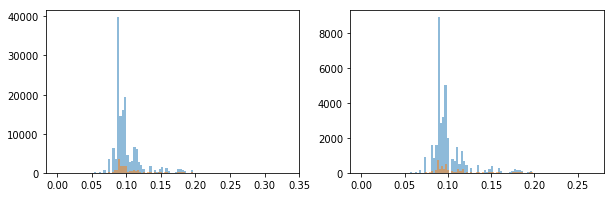

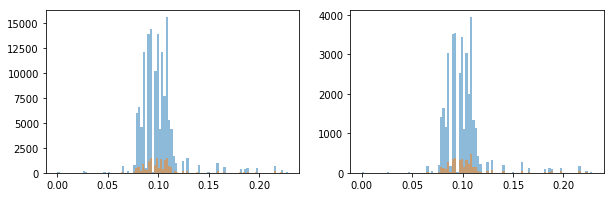

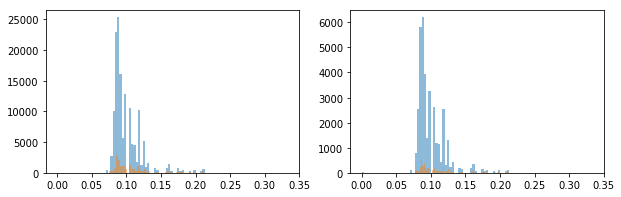

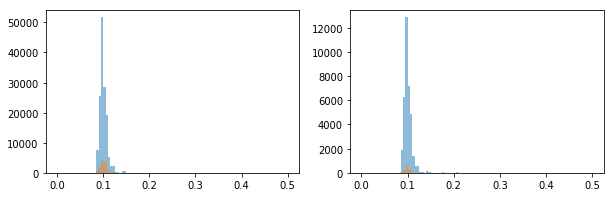

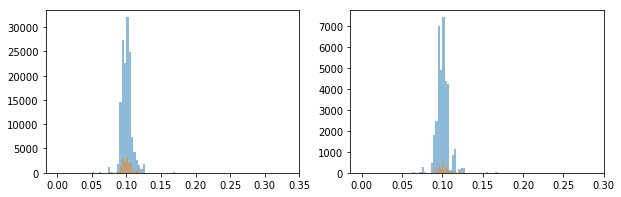

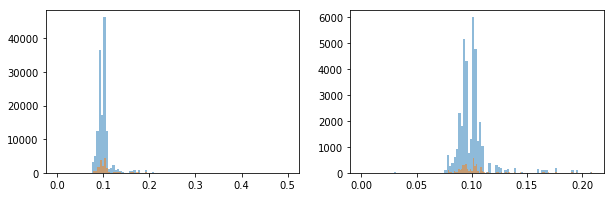

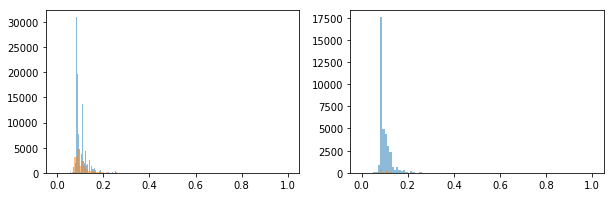

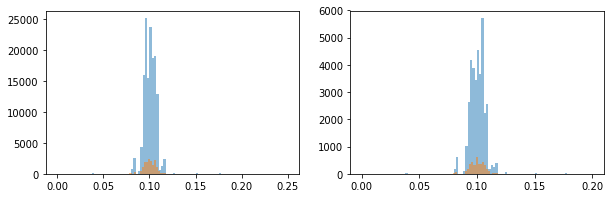

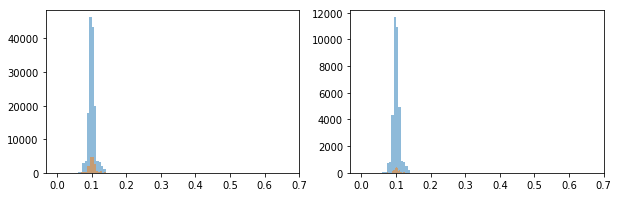

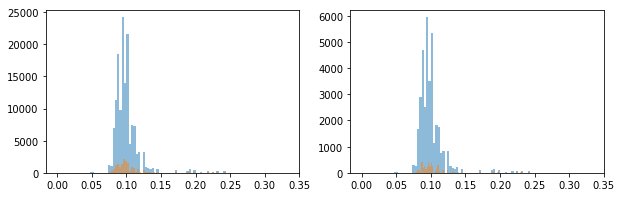

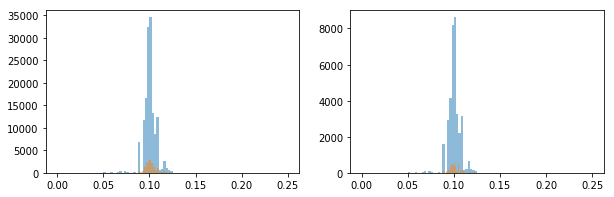

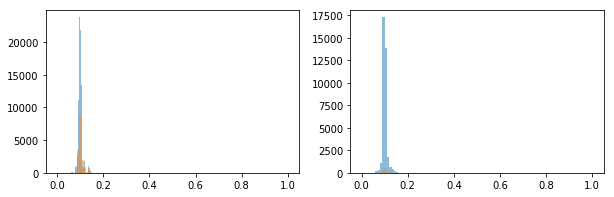

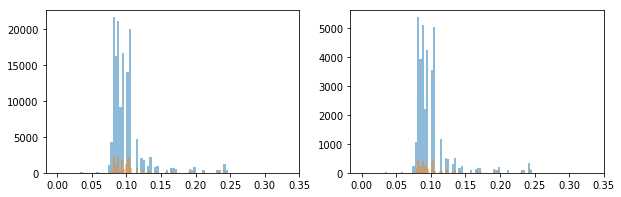

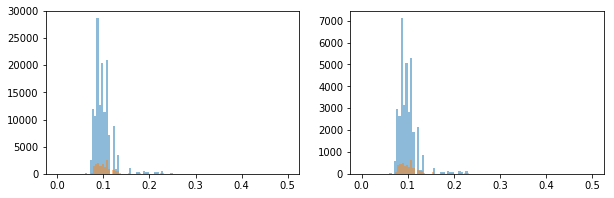

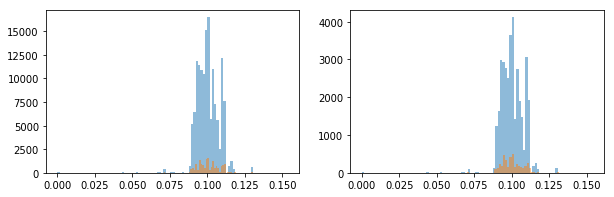

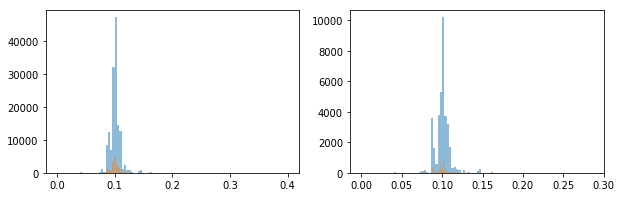

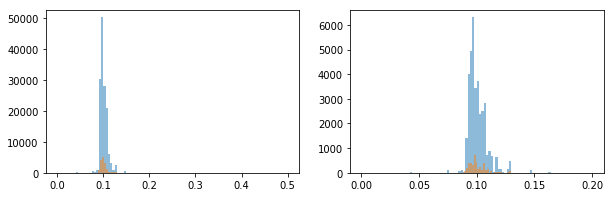

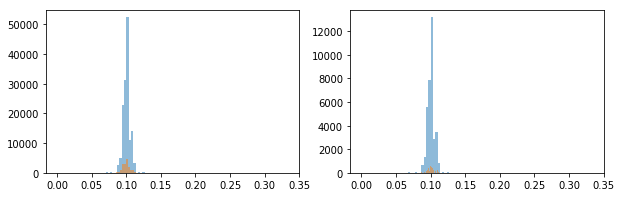

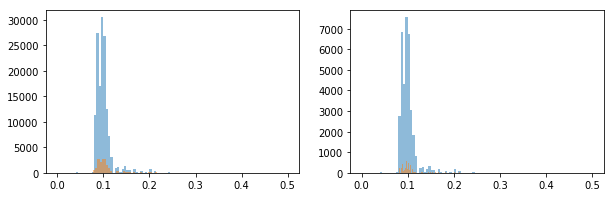

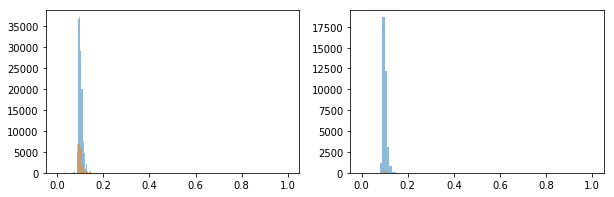

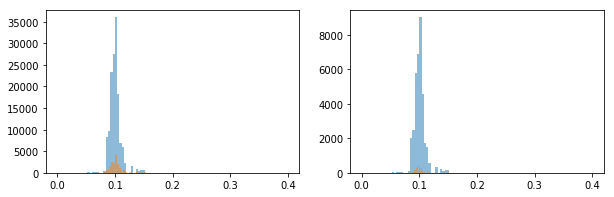

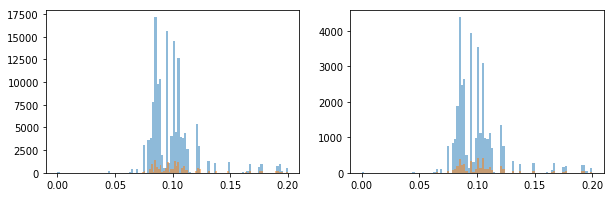

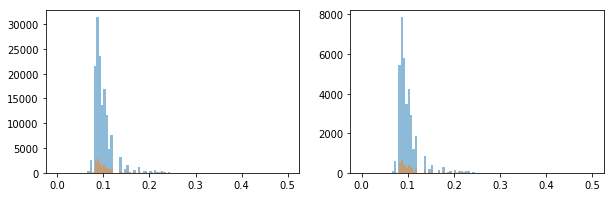

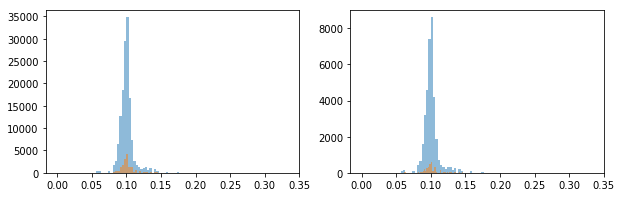

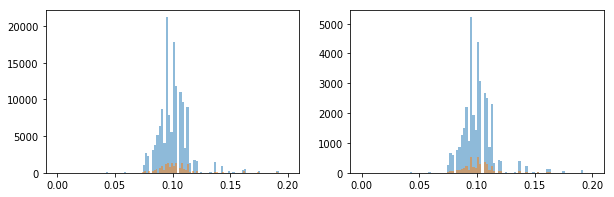

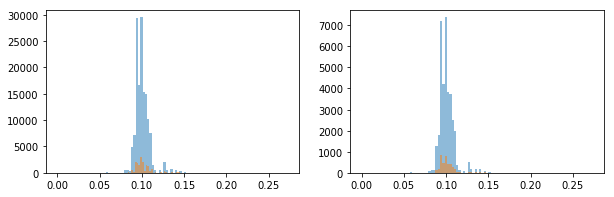

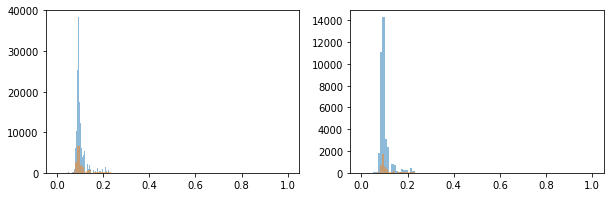

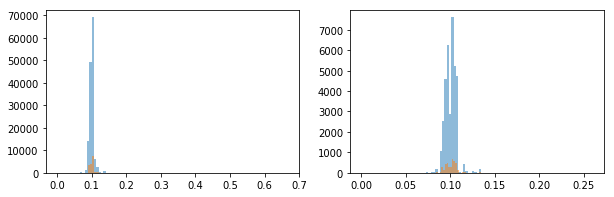

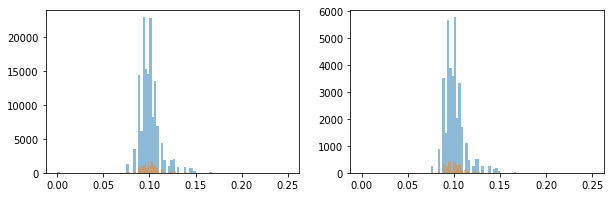

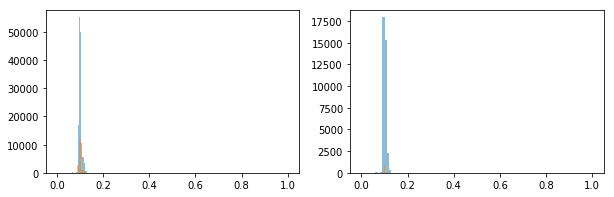

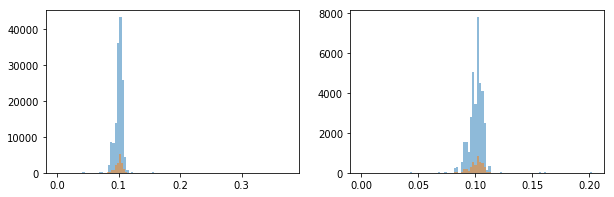

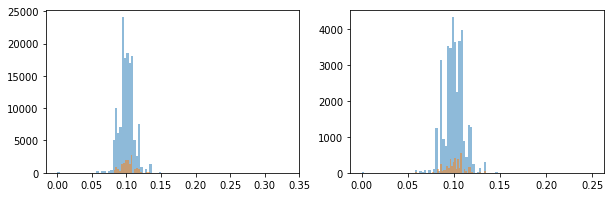

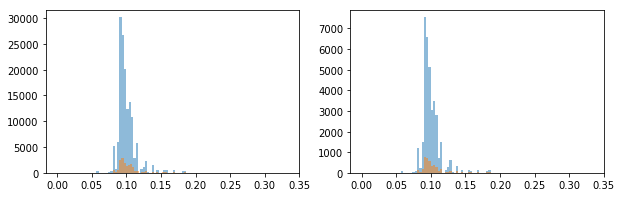

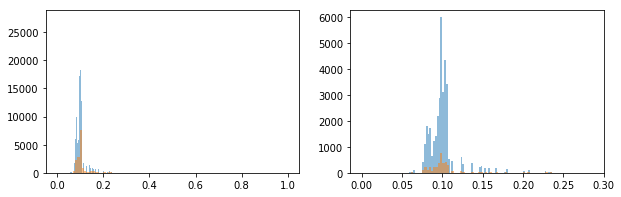

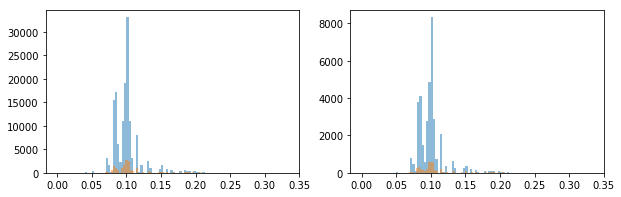

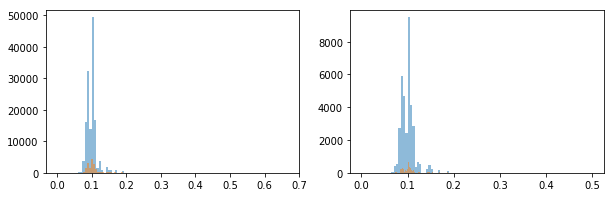

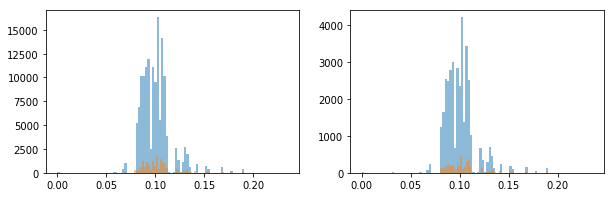

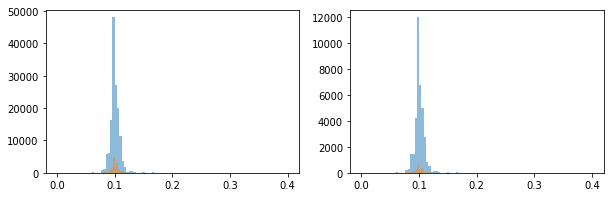

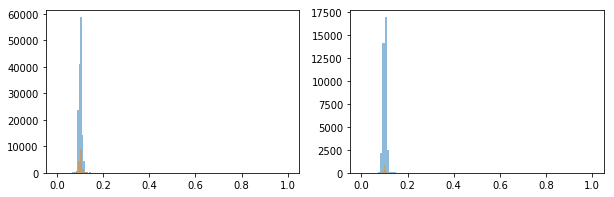

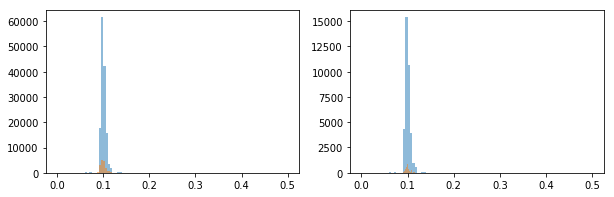

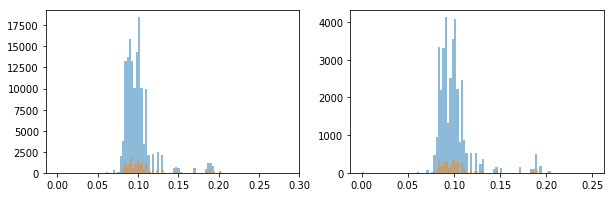

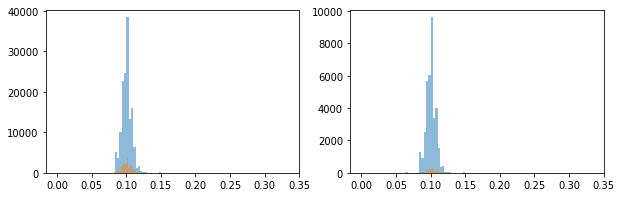

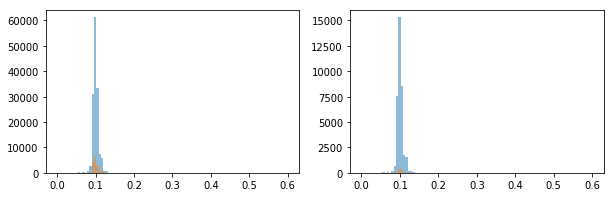

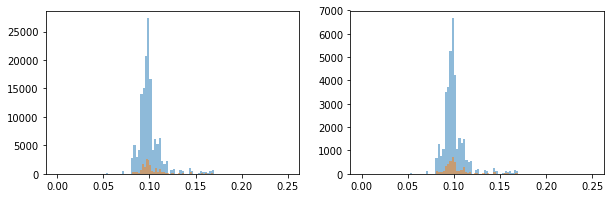

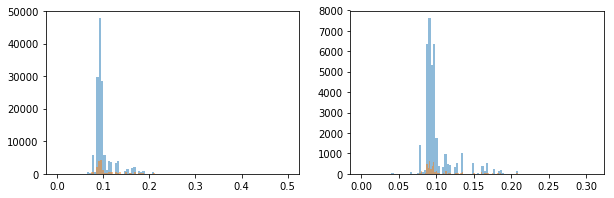

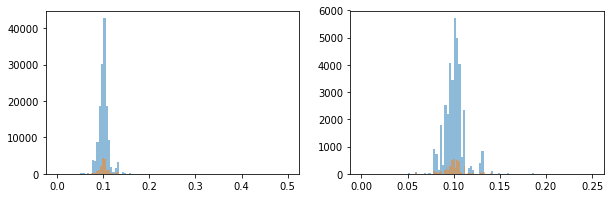

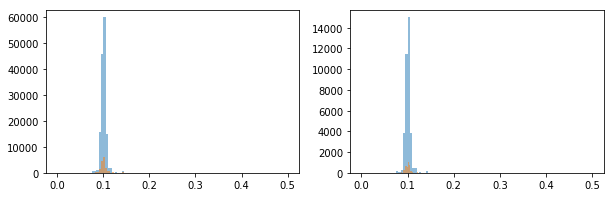

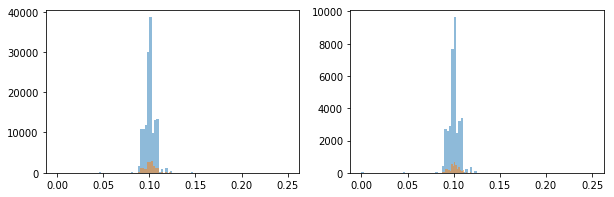

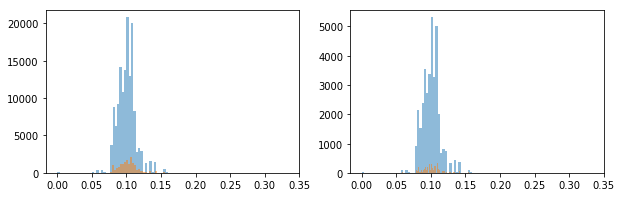

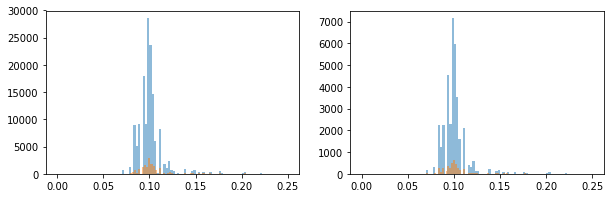

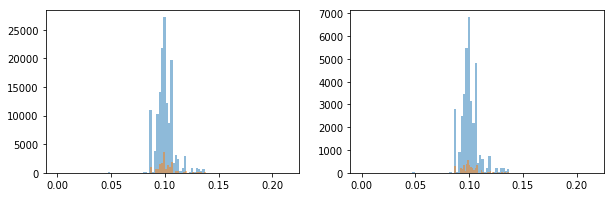

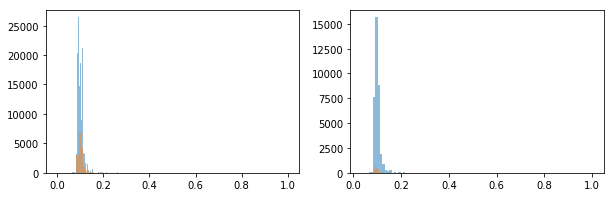

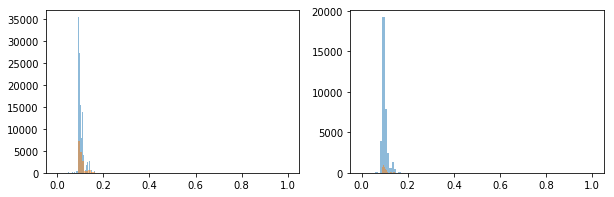

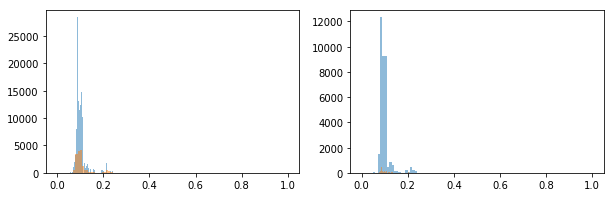

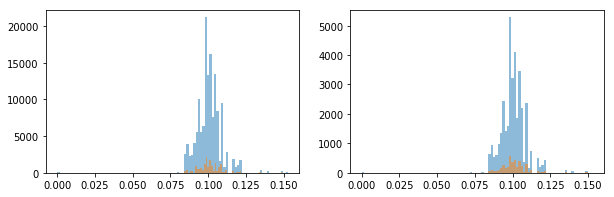

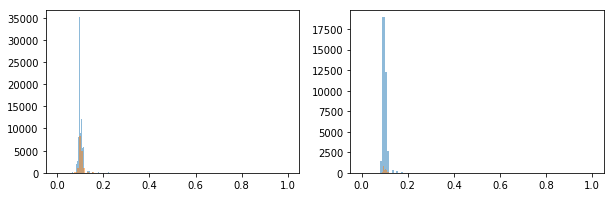

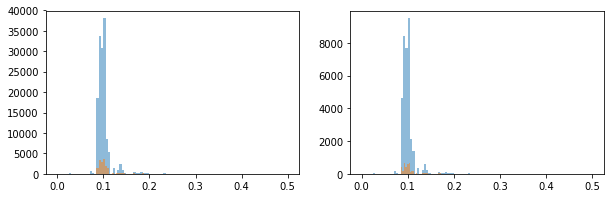

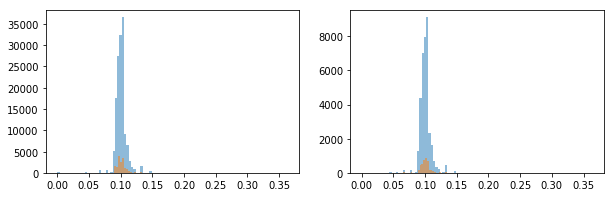

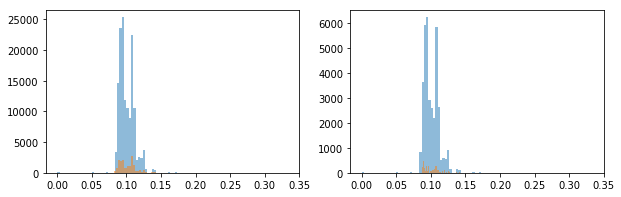

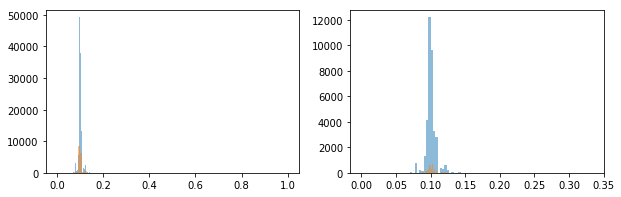

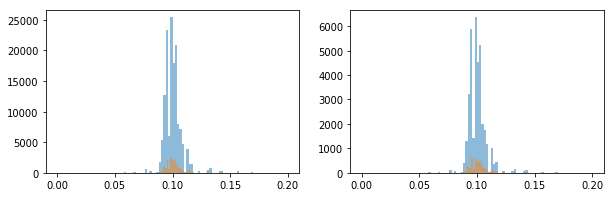

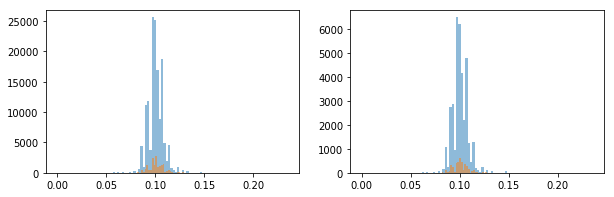

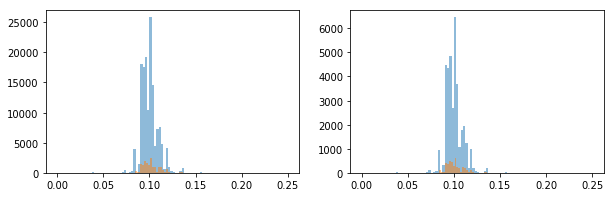

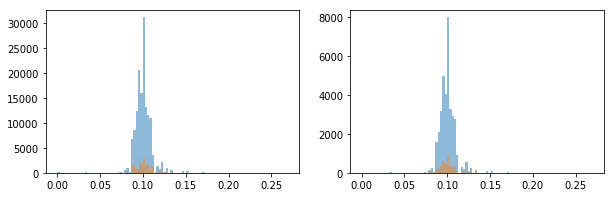

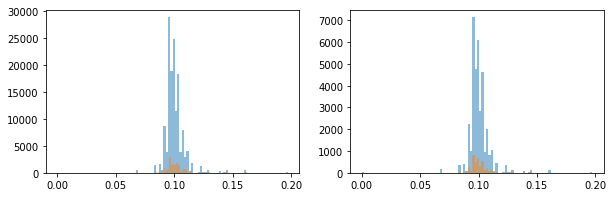

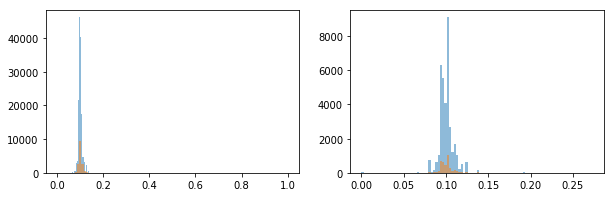

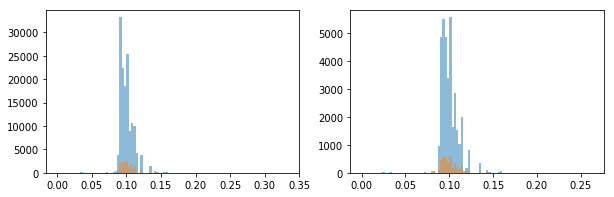

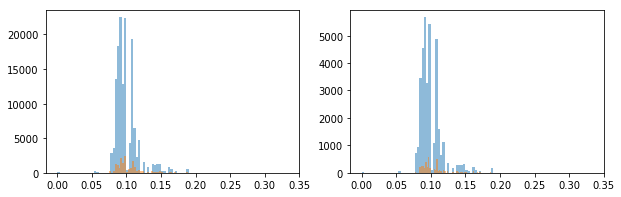

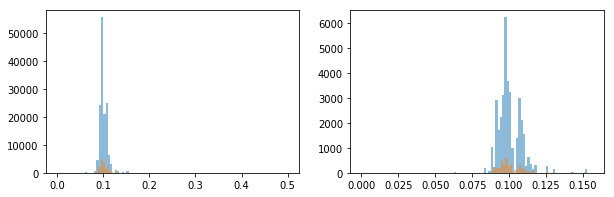

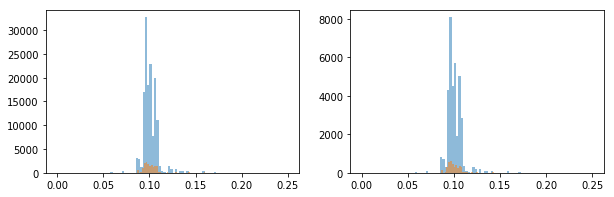

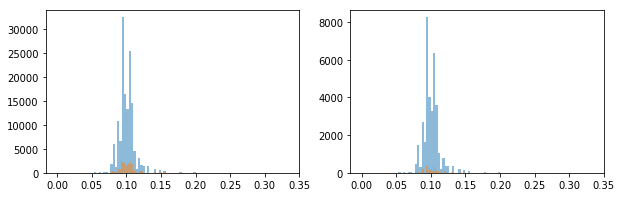

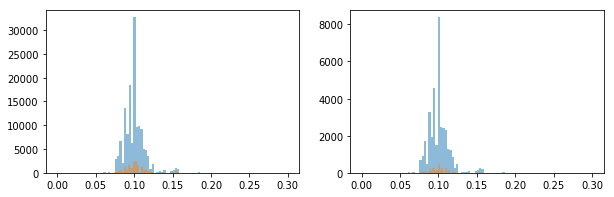

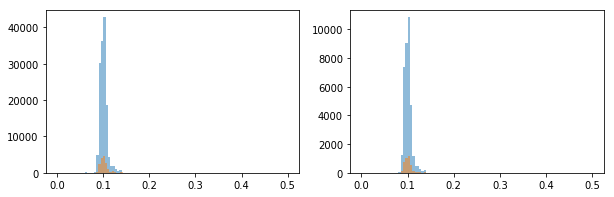

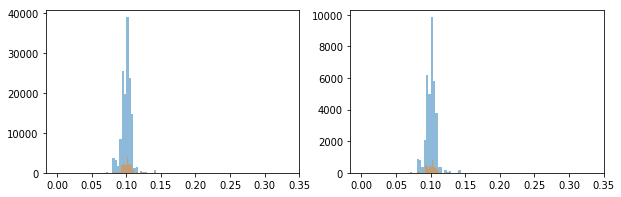

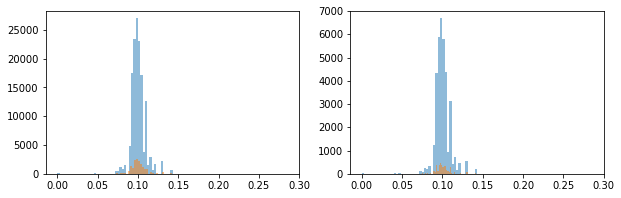

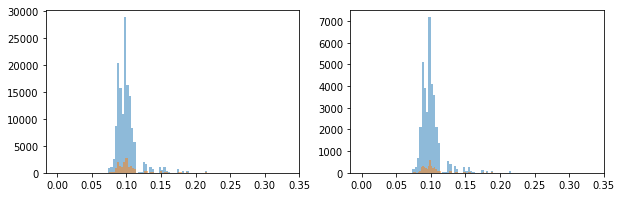

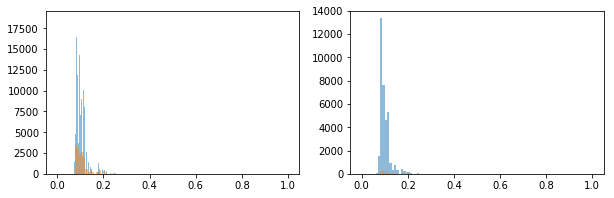

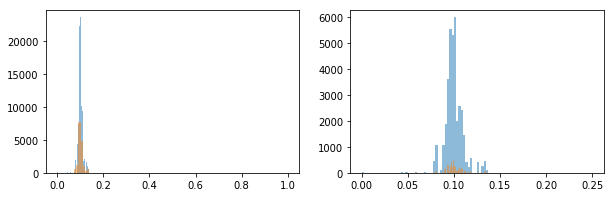

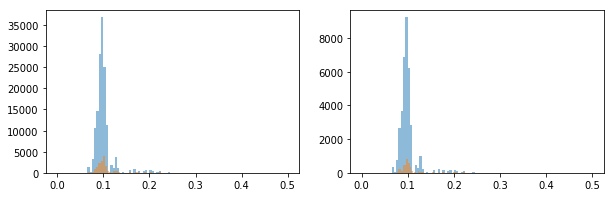

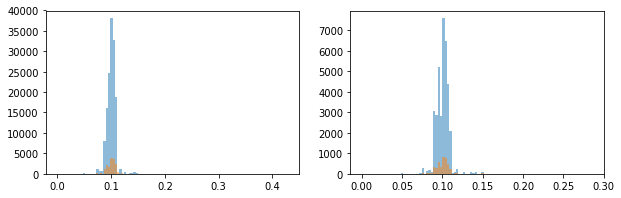

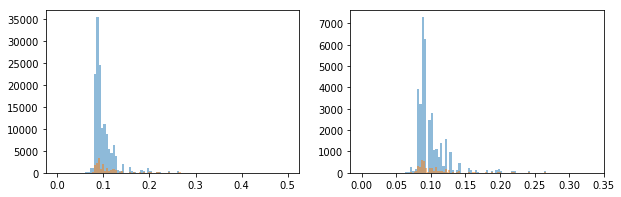

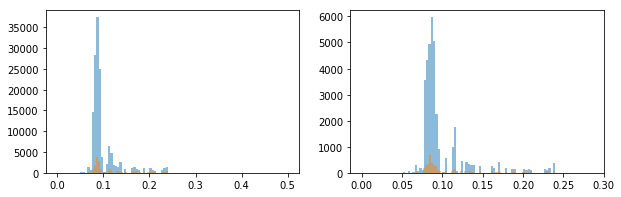

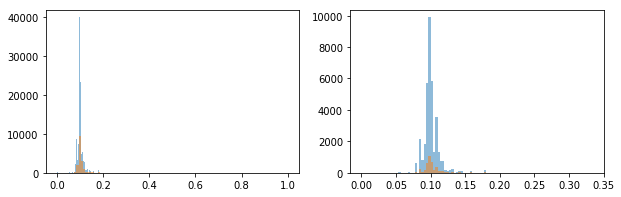

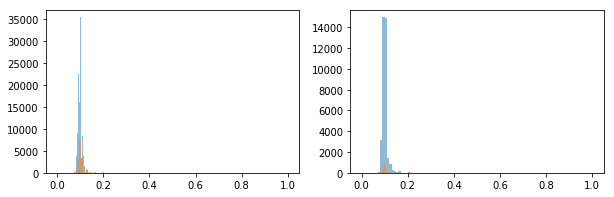

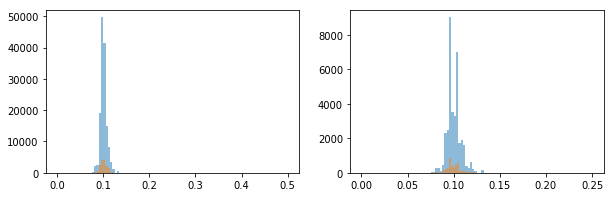

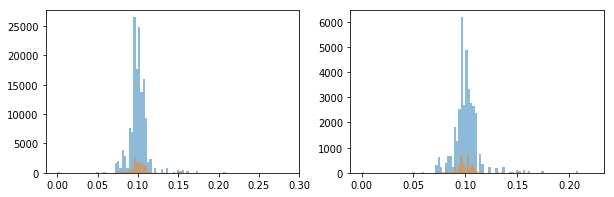

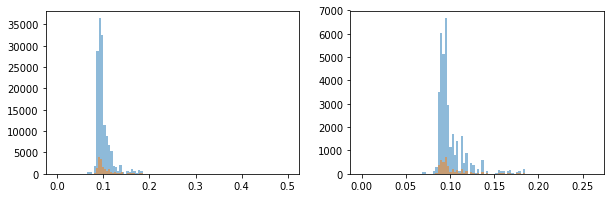

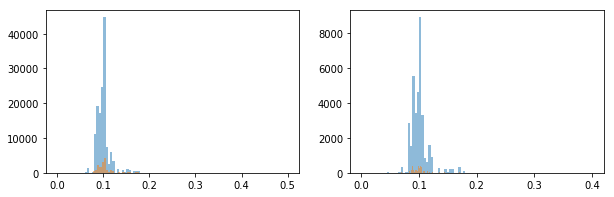

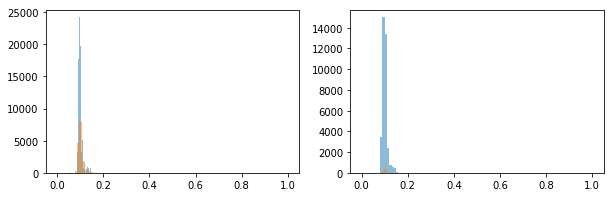

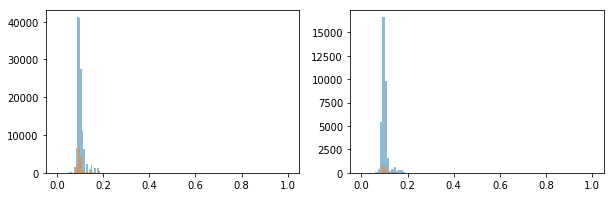

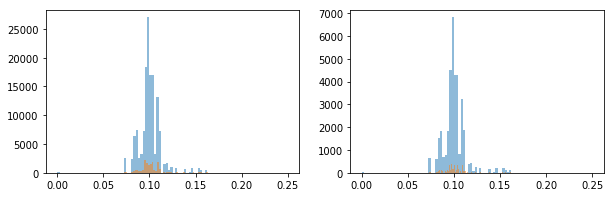

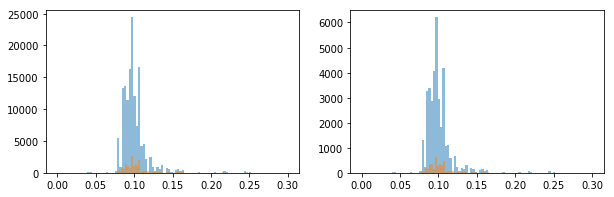

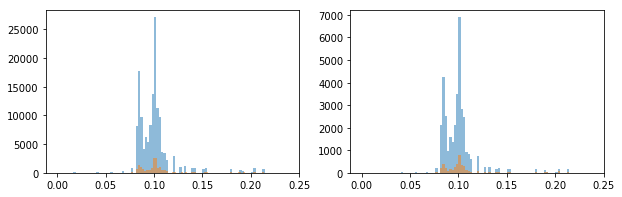

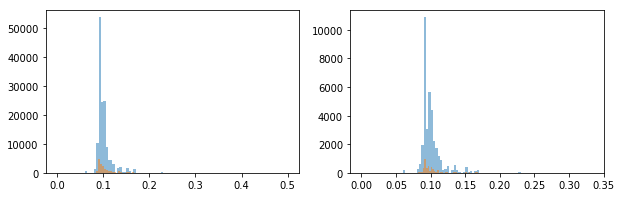

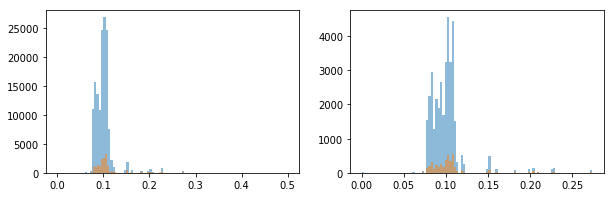

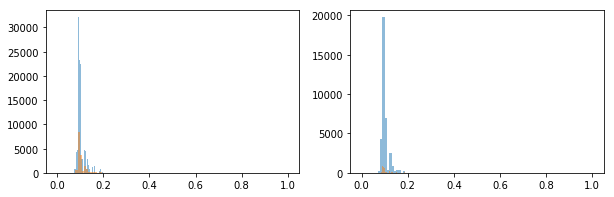

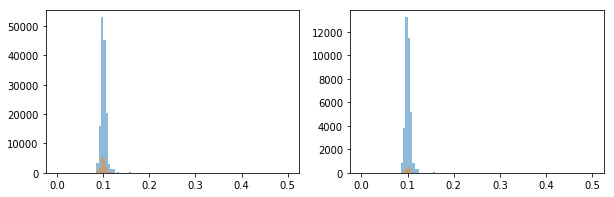

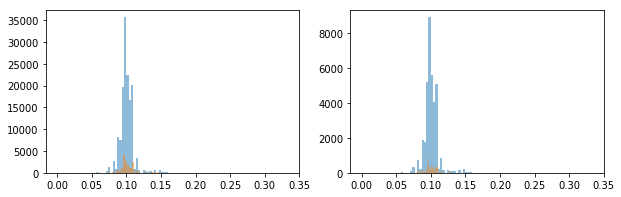

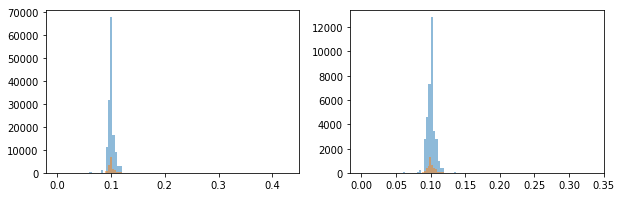

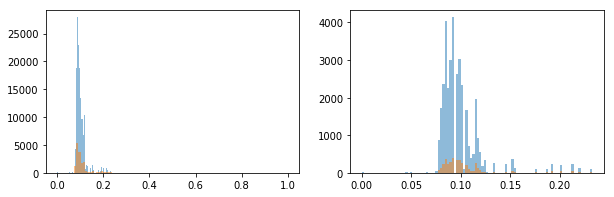

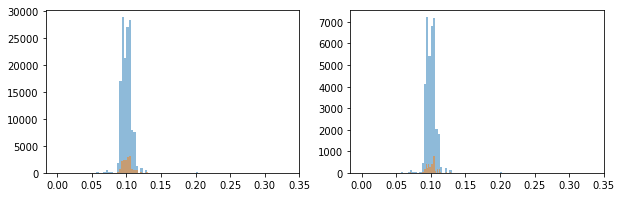

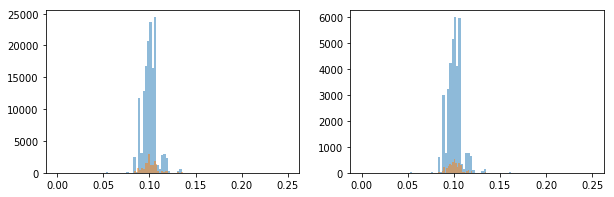

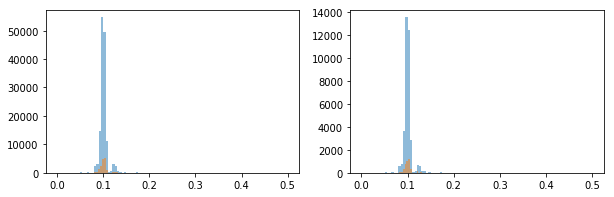

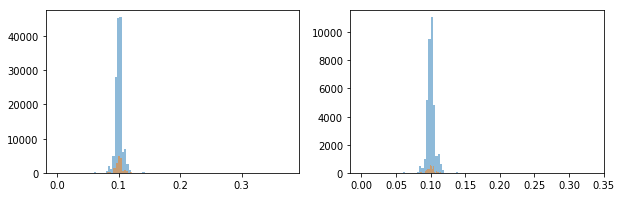

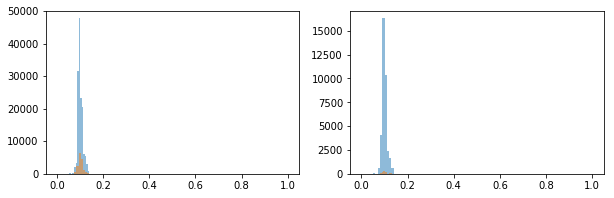

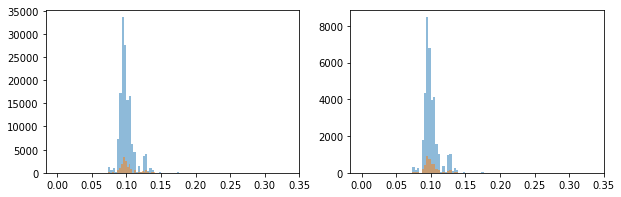

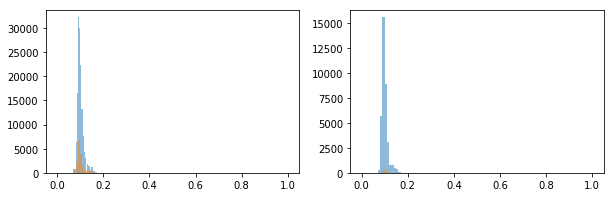

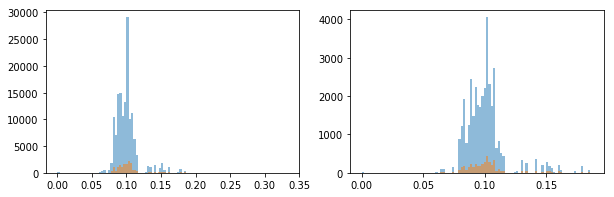

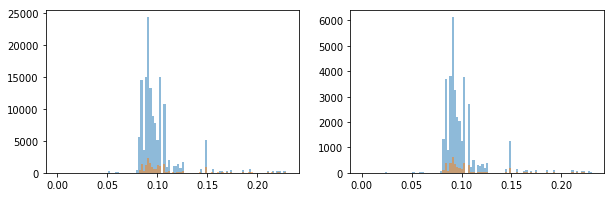

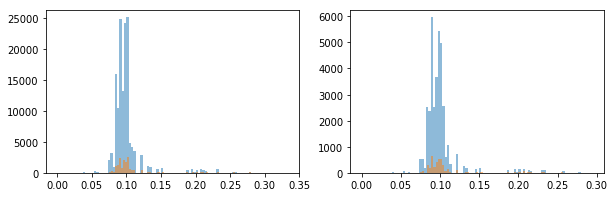

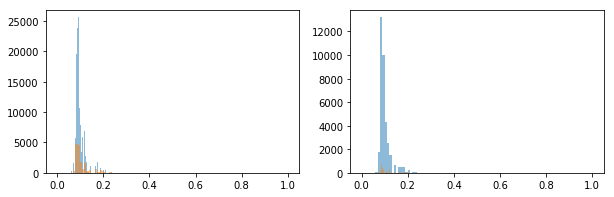

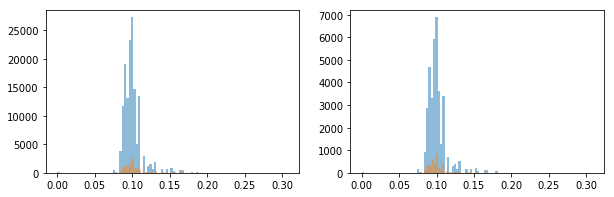

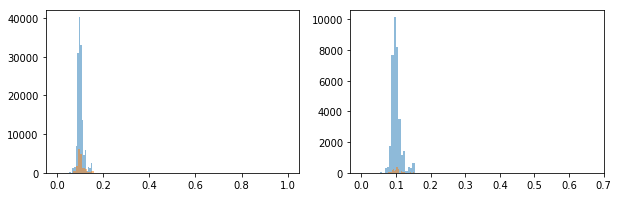

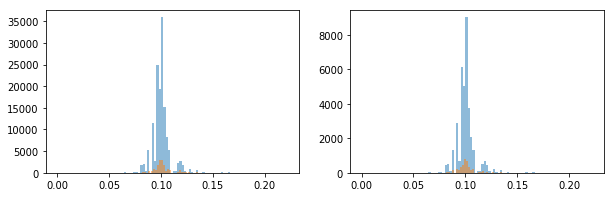

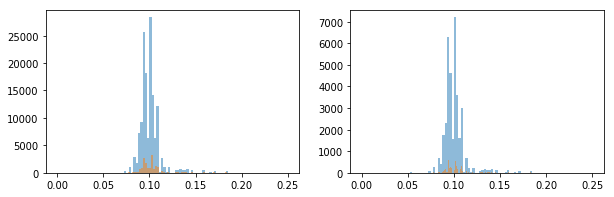

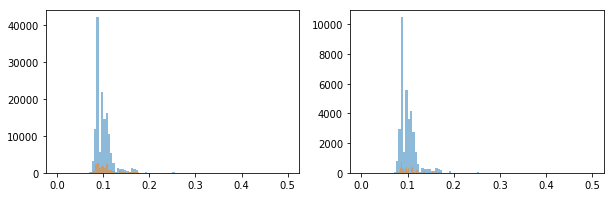

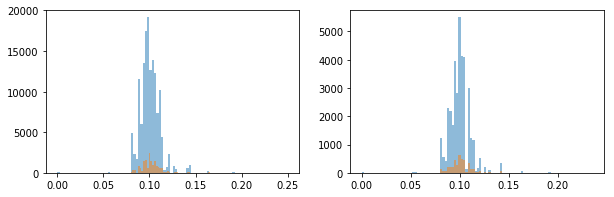

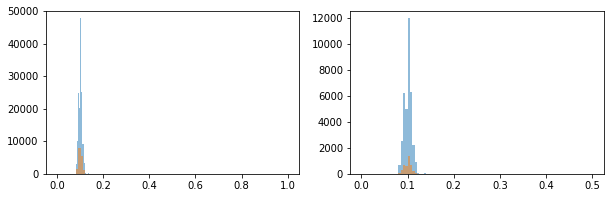

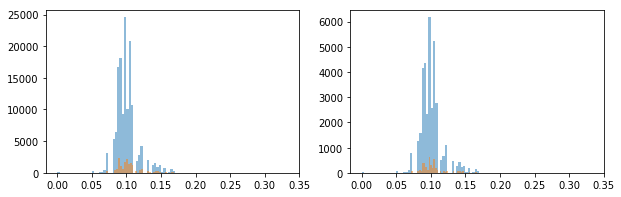

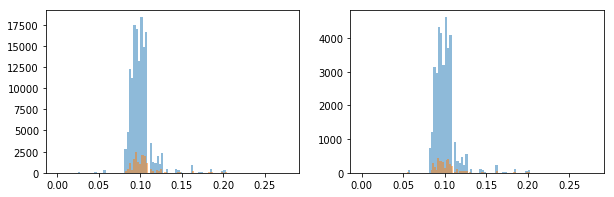

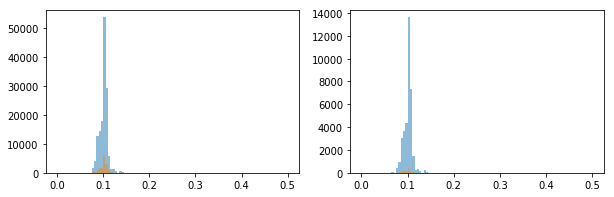

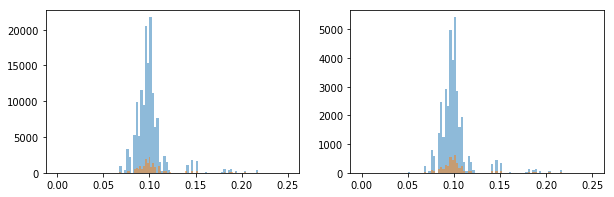

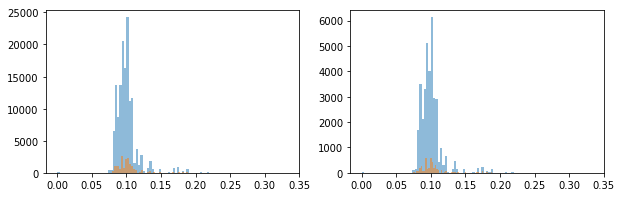

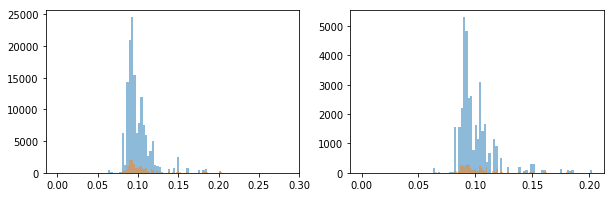

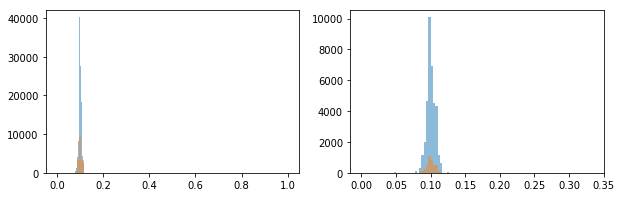

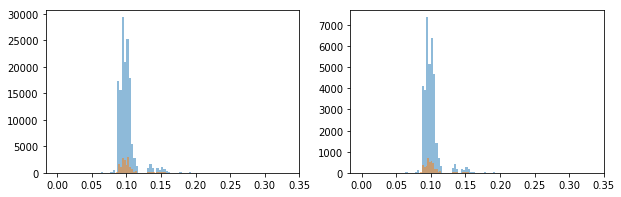

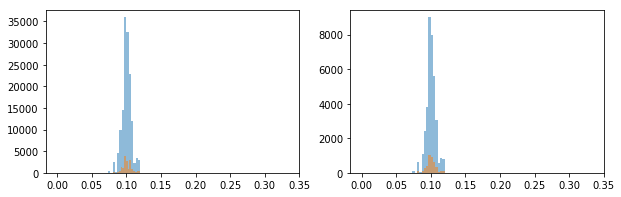

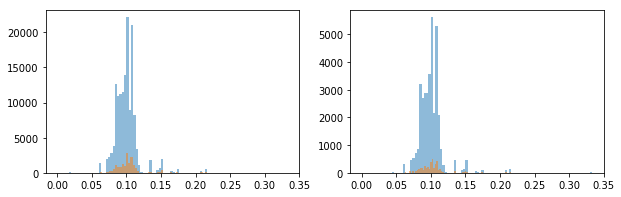

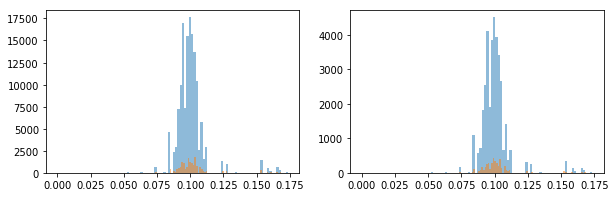

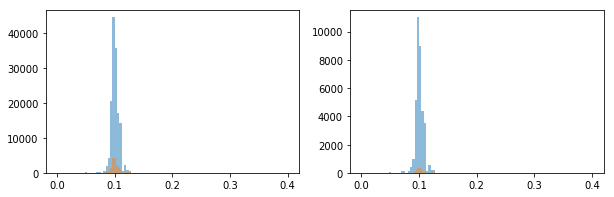

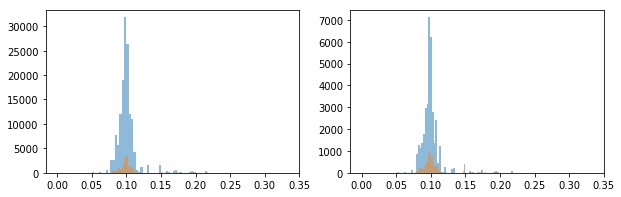

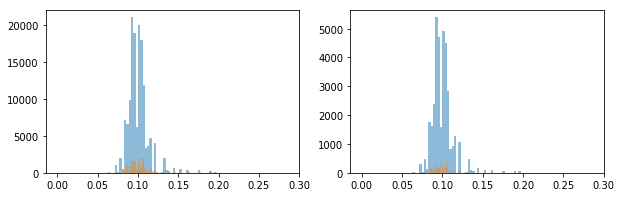

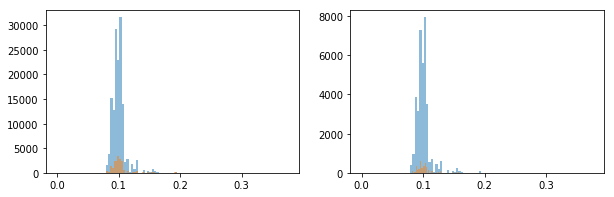

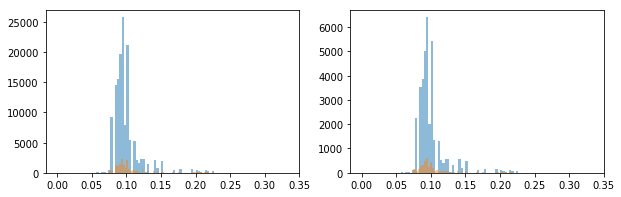

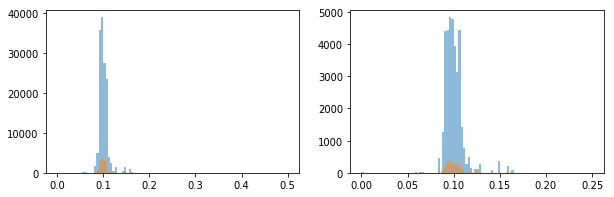

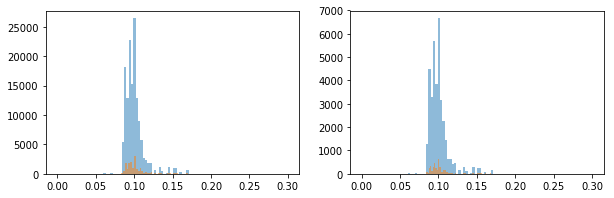

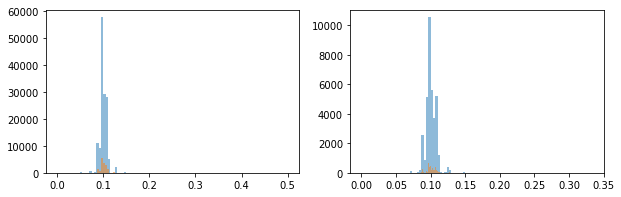

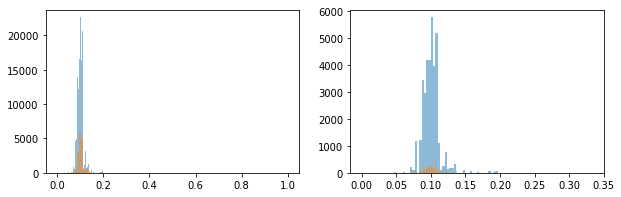

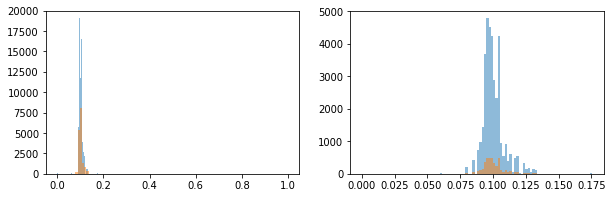

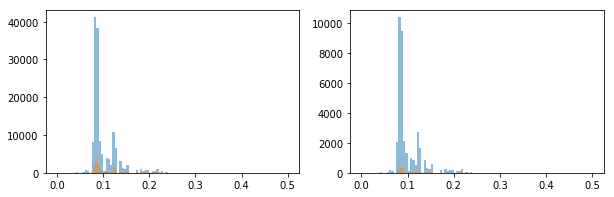

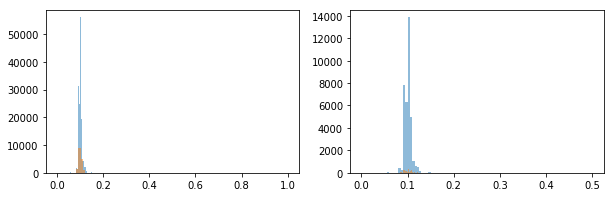

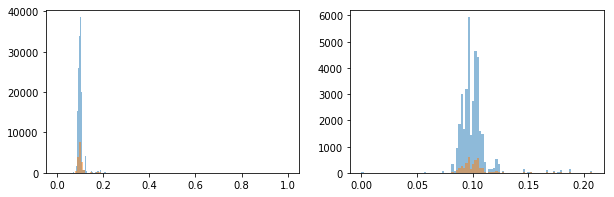

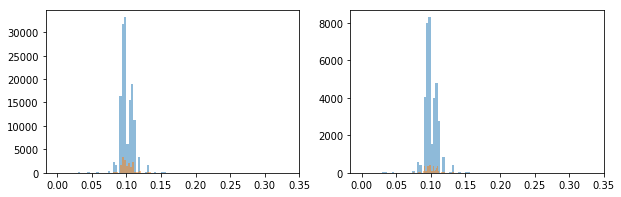

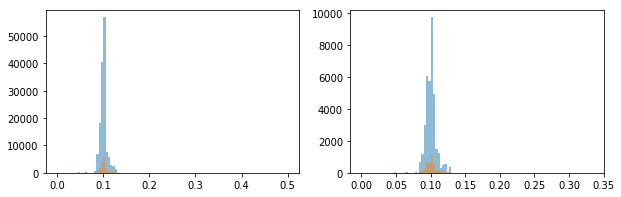

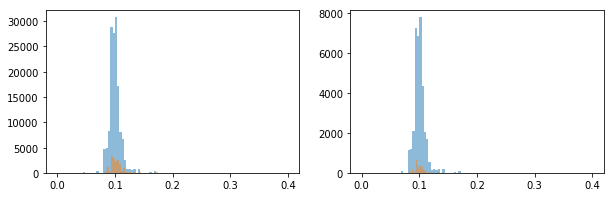

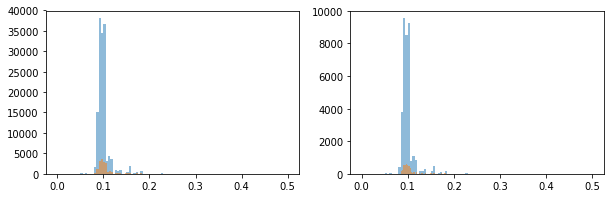

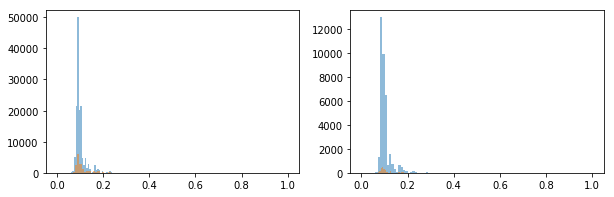

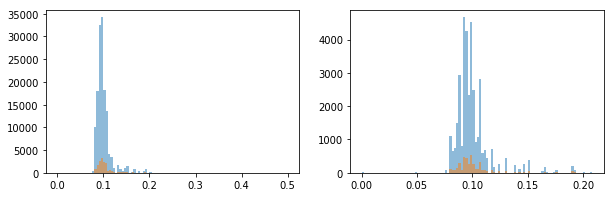

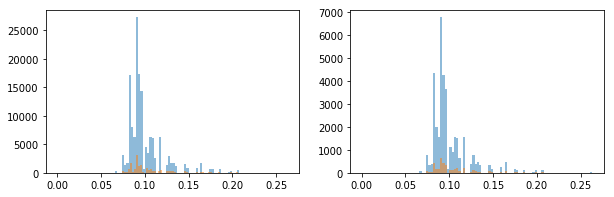

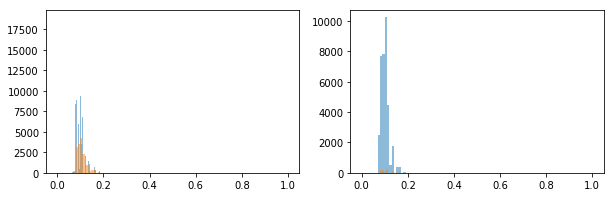

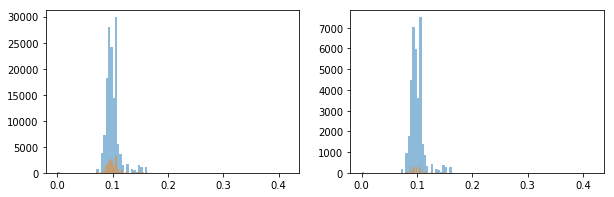

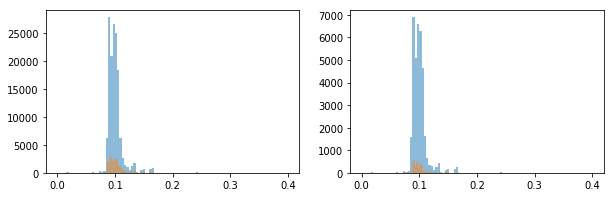

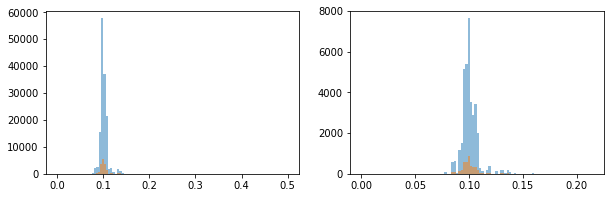

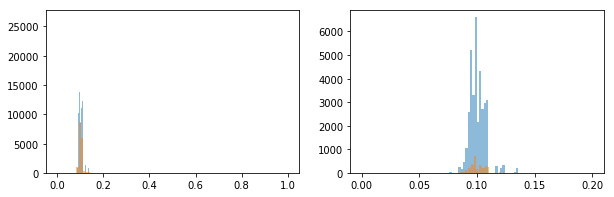

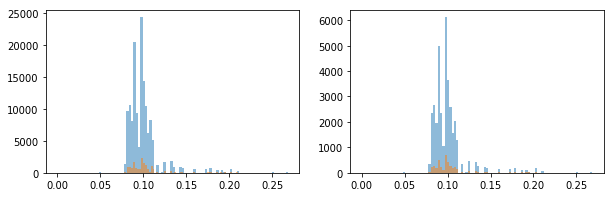

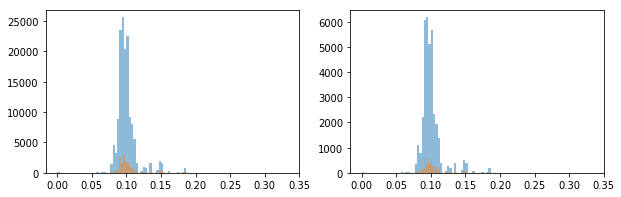

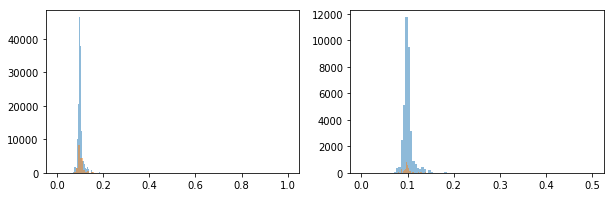

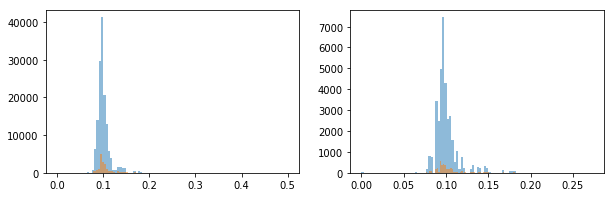

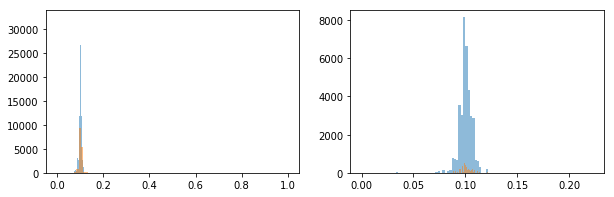

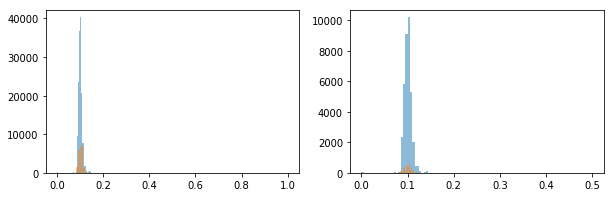

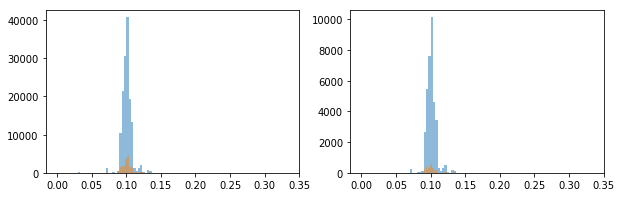

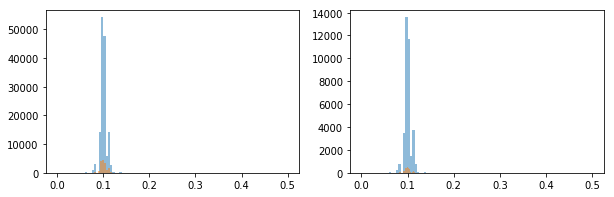

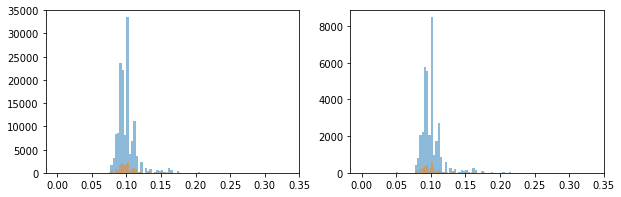

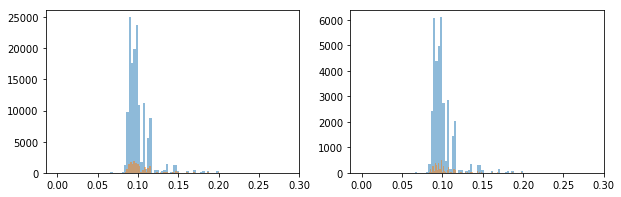

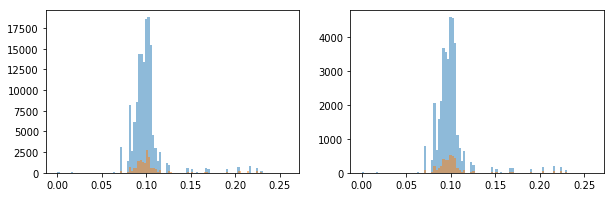

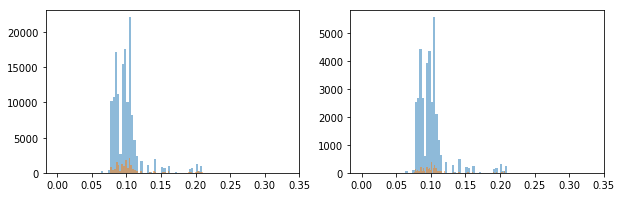

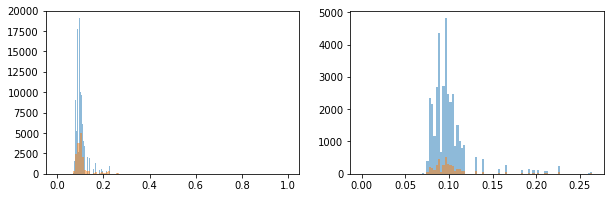

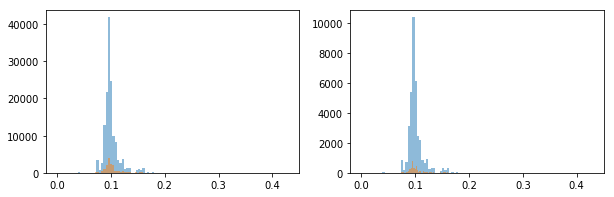

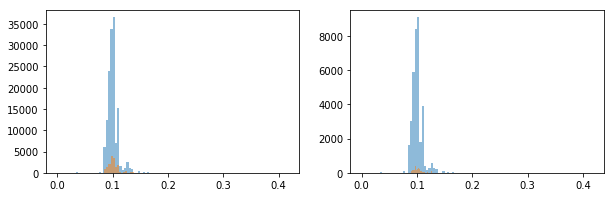

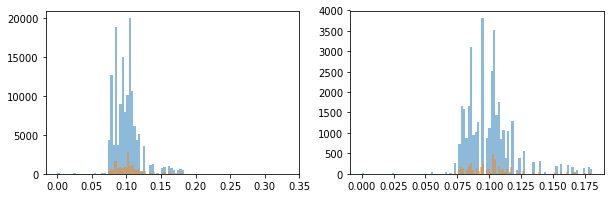

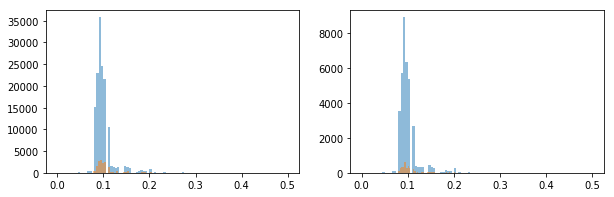

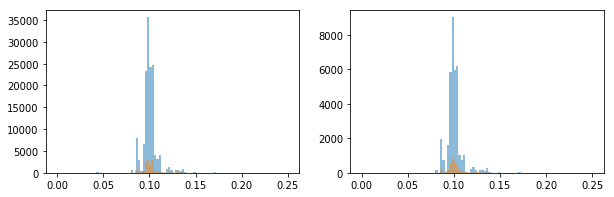

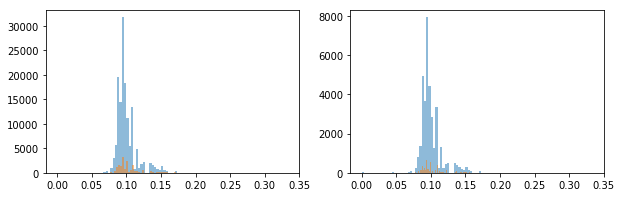

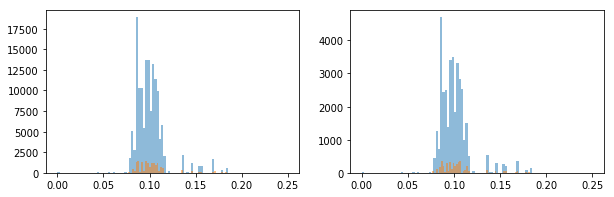

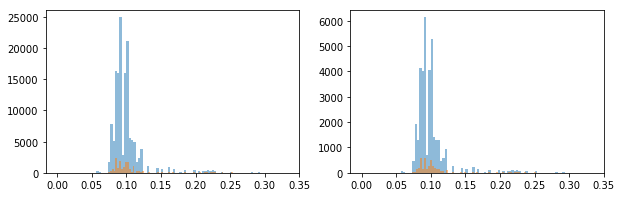

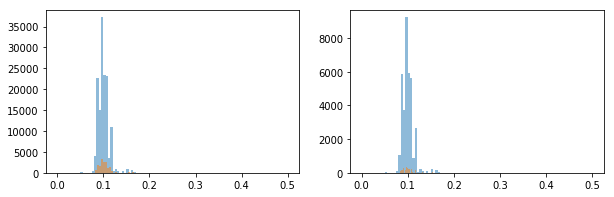

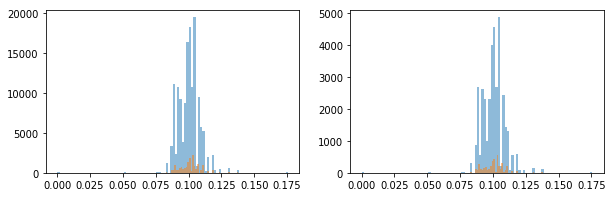

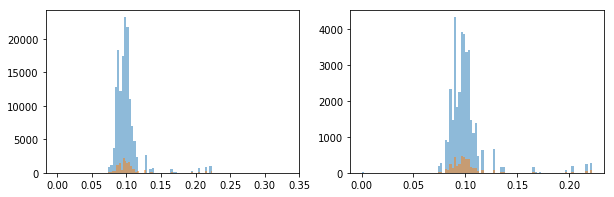

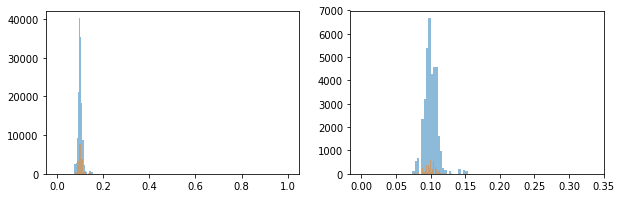

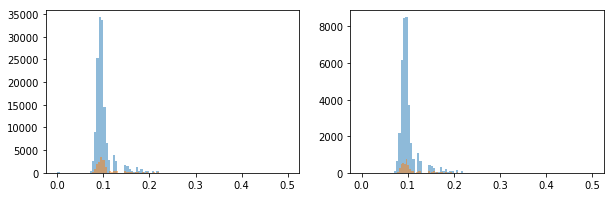

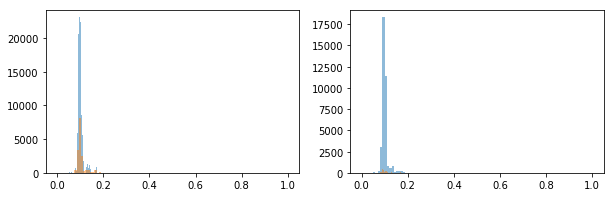

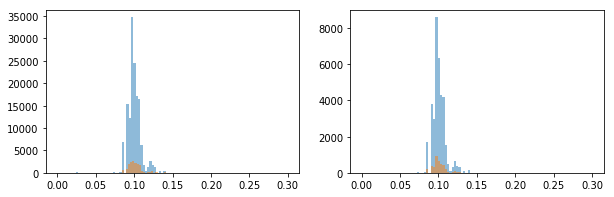

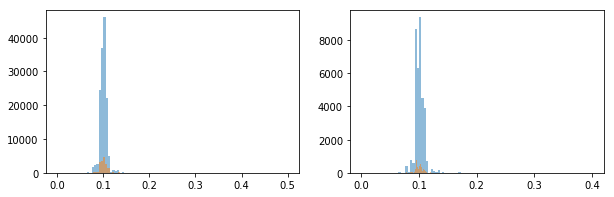

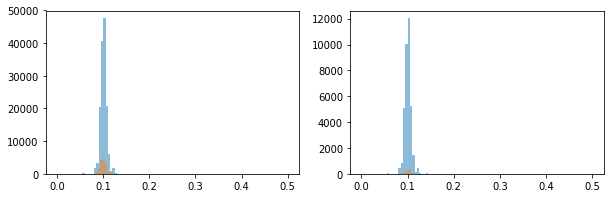

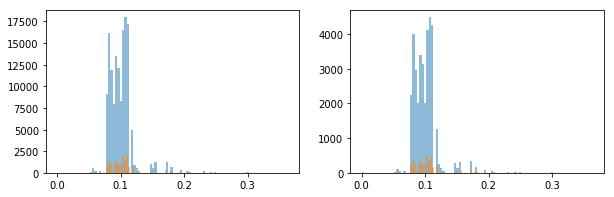

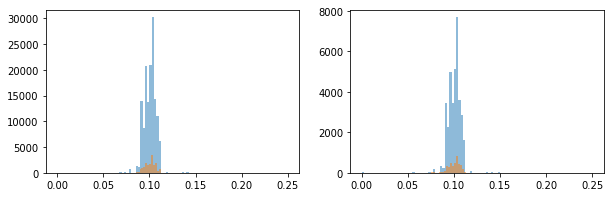

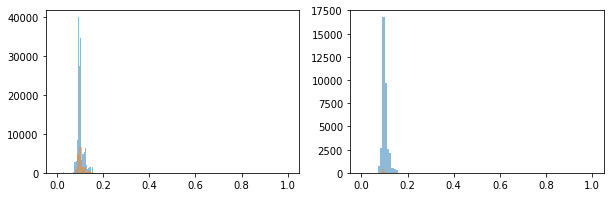

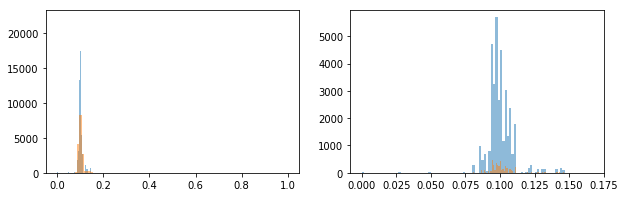

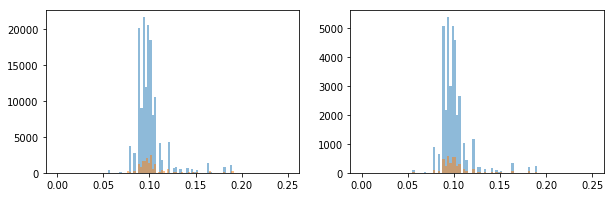

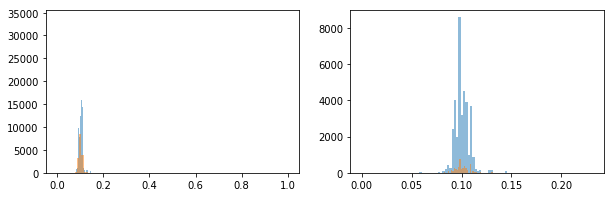

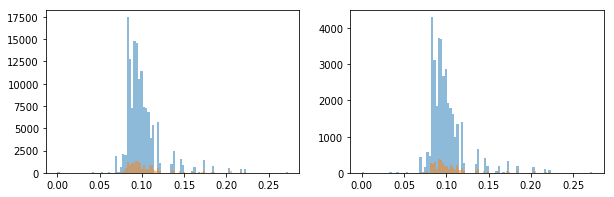

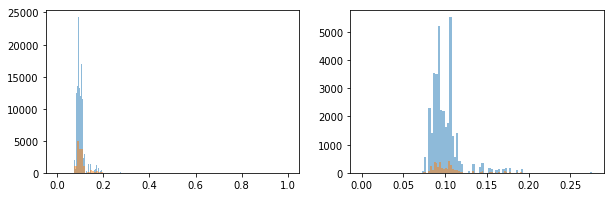

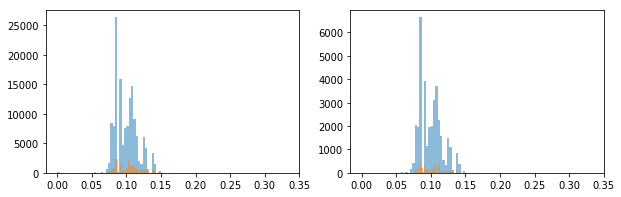

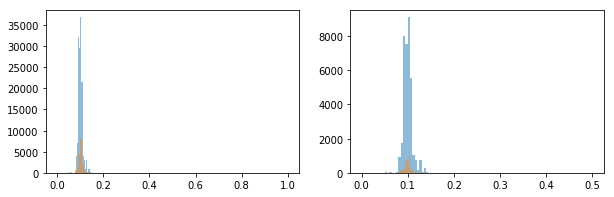

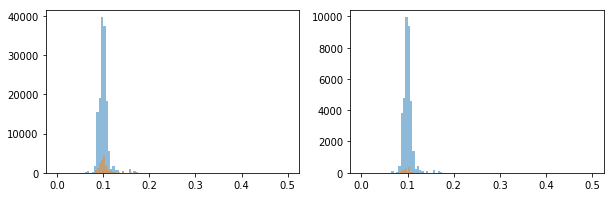

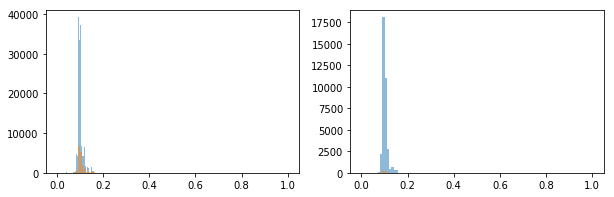

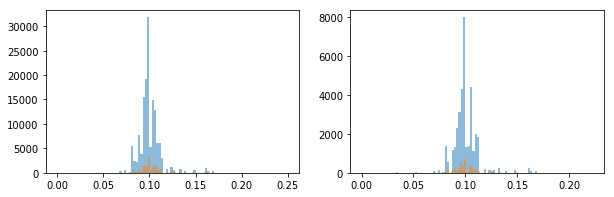

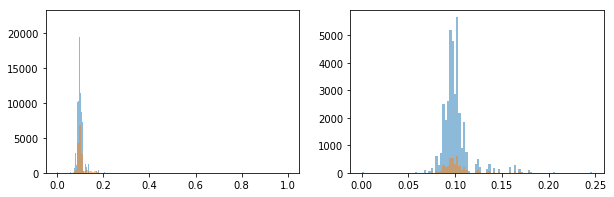

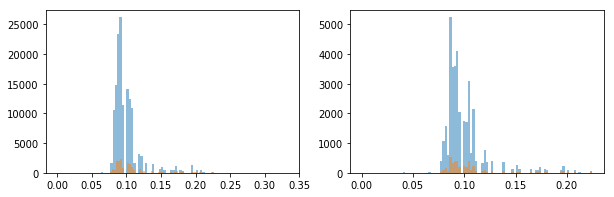

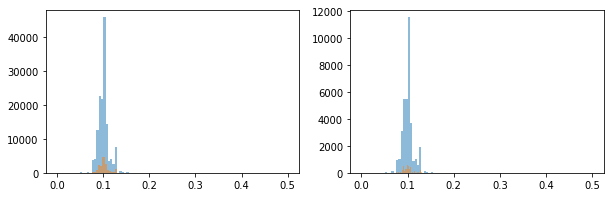

In [14]:
for i in range(200):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.hist(post_train[:, i][neg_mask_train], bins=100, alpha=0.5)
    plt.hist(post_train[:, i][pos_mask_train], bins=100, alpha=0.5)
    
    plt.subplot(1,2,2)
    plt.hist(post_val[:, i][neg_mask_val], bins=100, alpha=0.5)
    plt.hist(post_val[:, i][pos_mask_val], bins=100, alpha=0.5)
    plt.show()

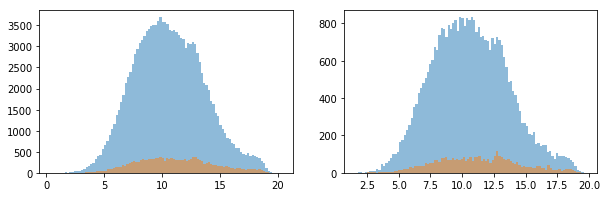

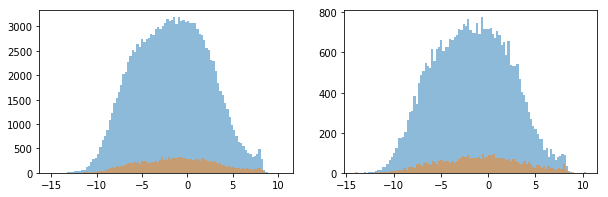

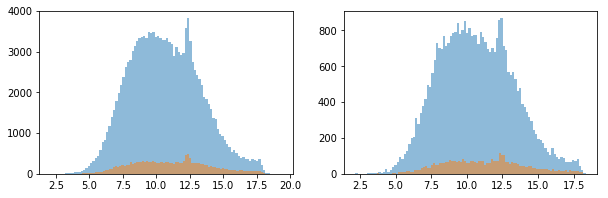

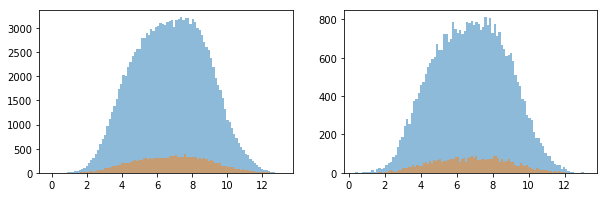

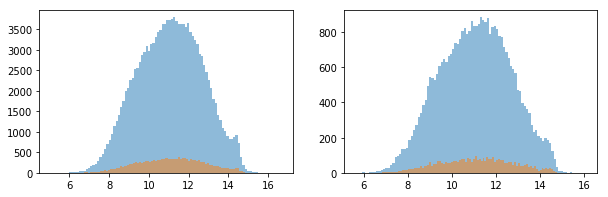

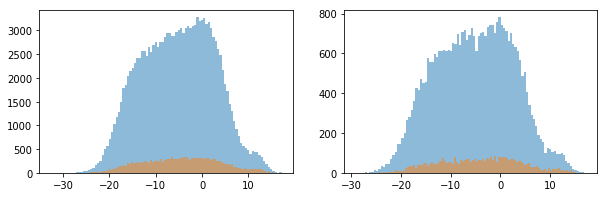

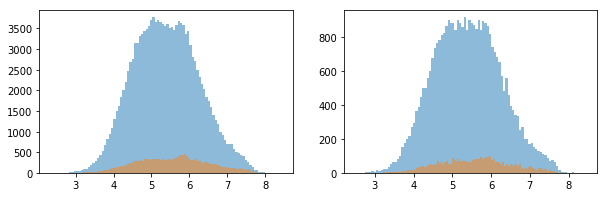

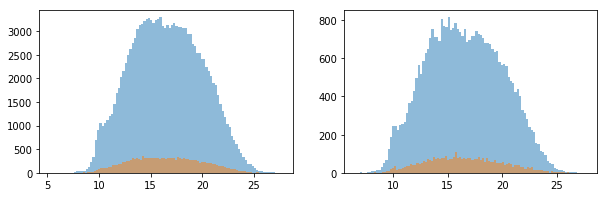

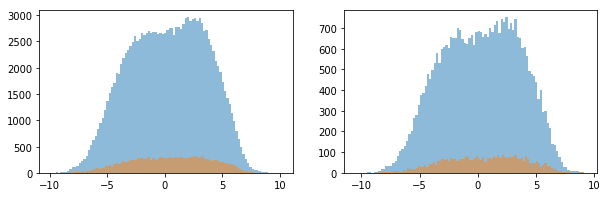

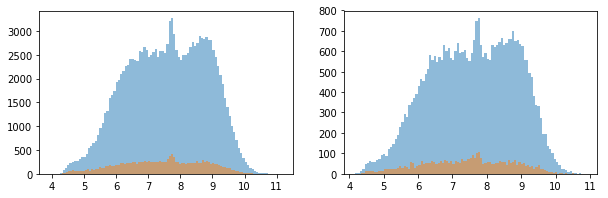

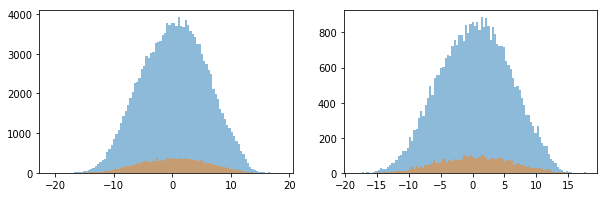

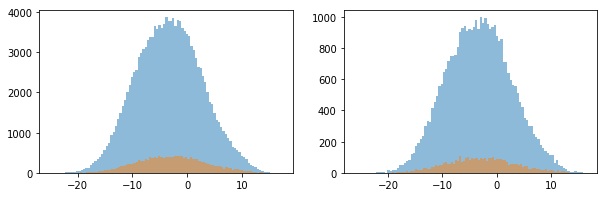

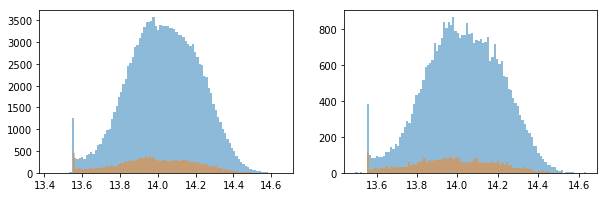

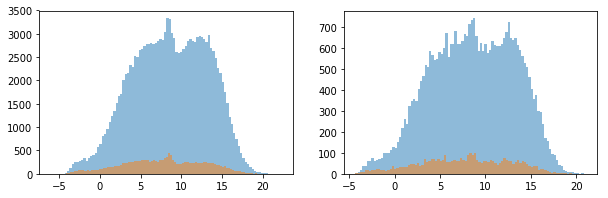

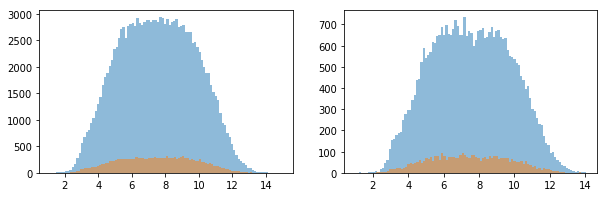

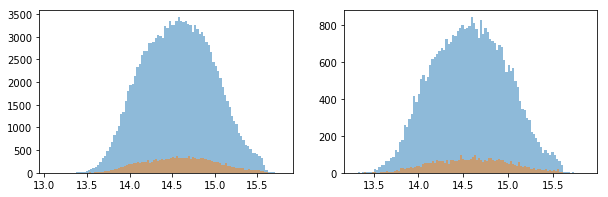

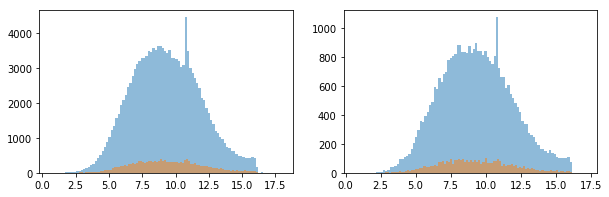

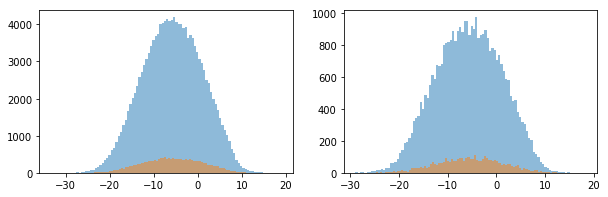

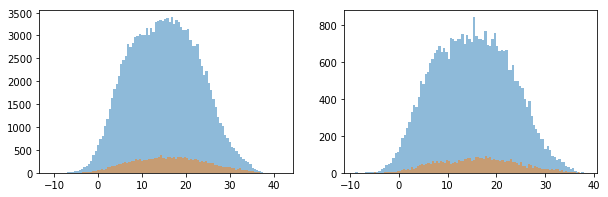

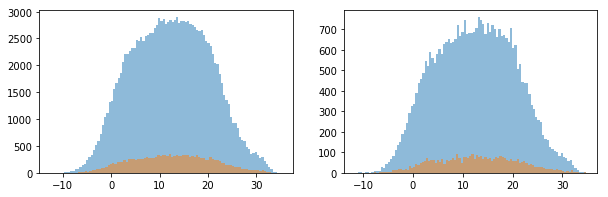

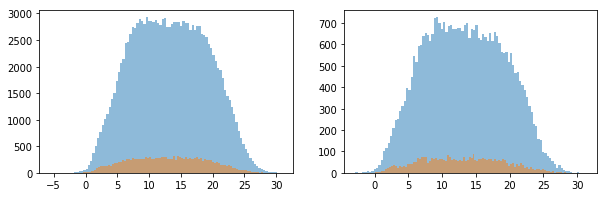

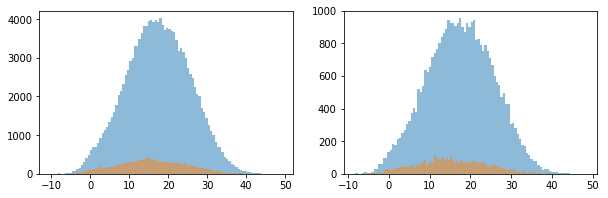

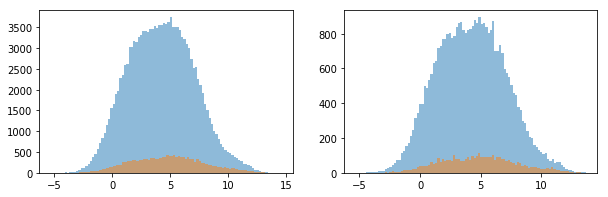

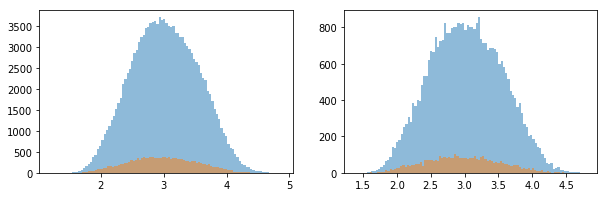

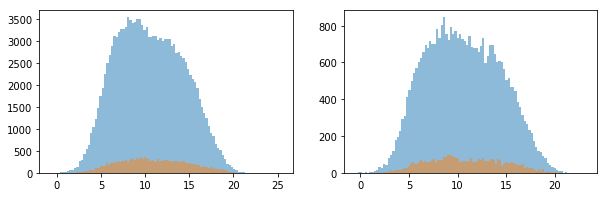

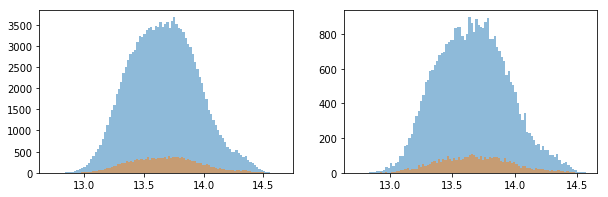

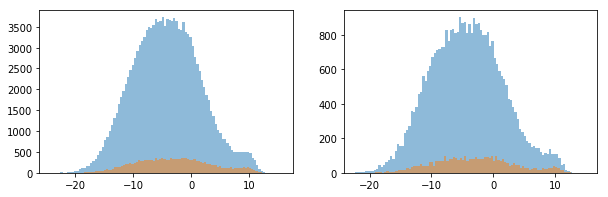

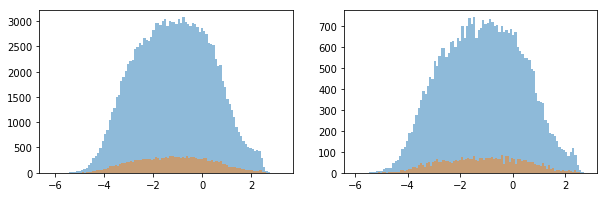

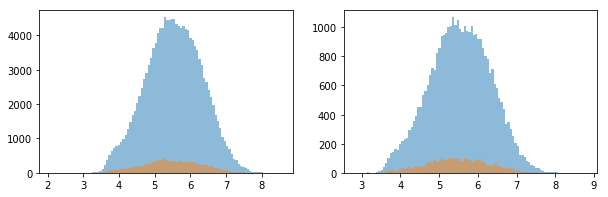

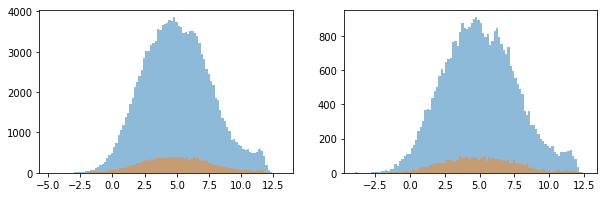

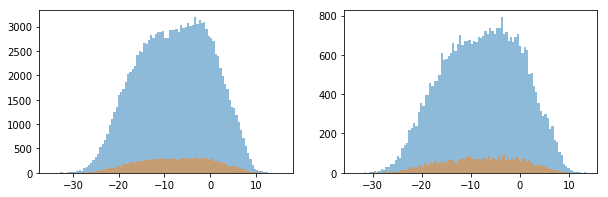

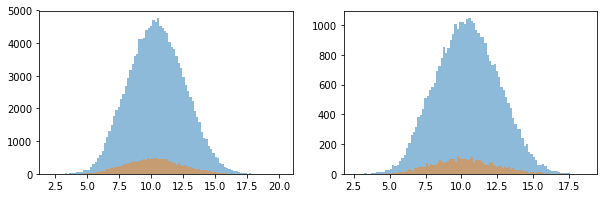

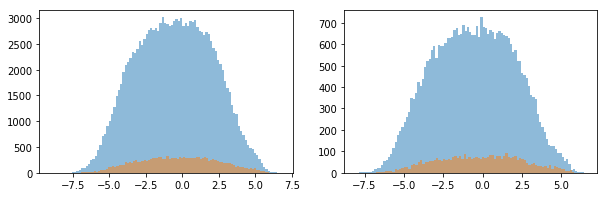

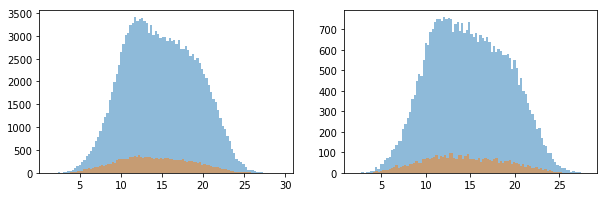

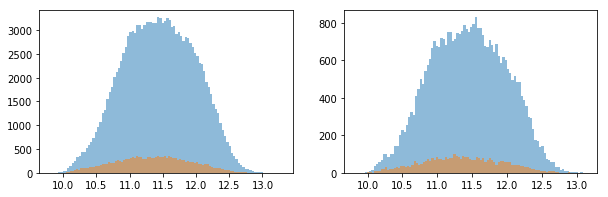

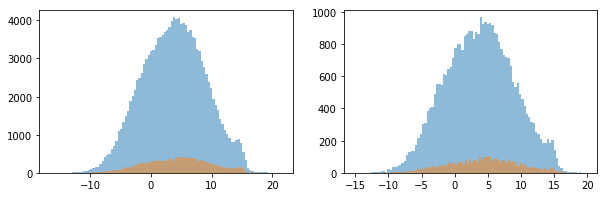

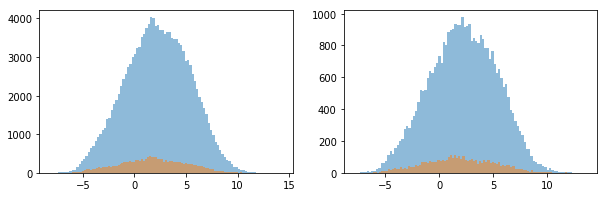

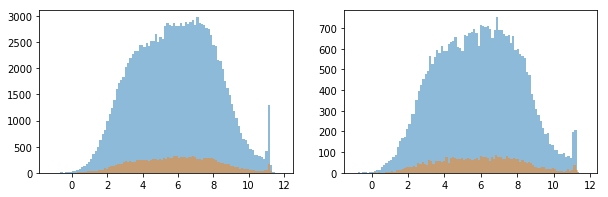

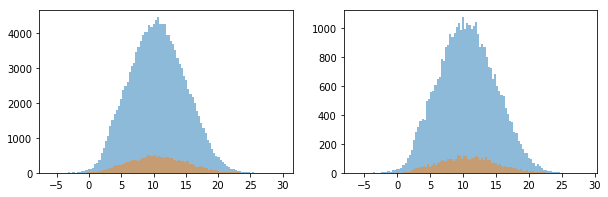

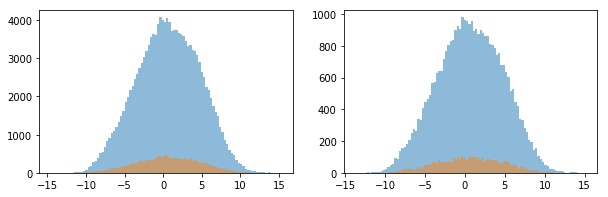

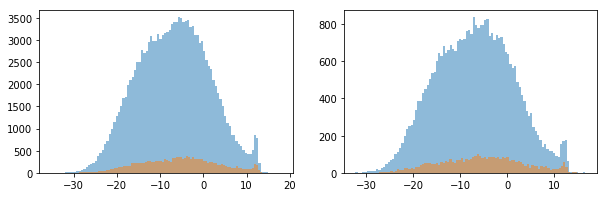

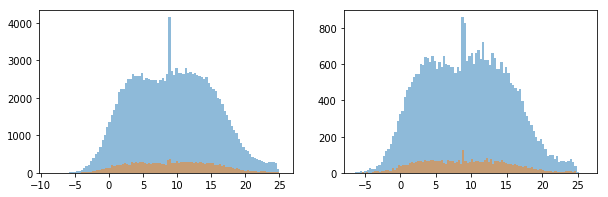

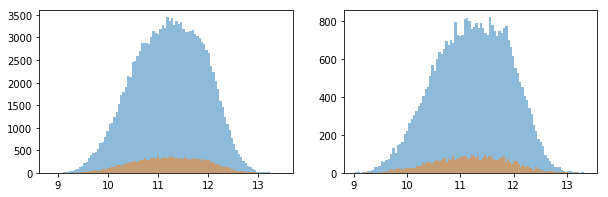

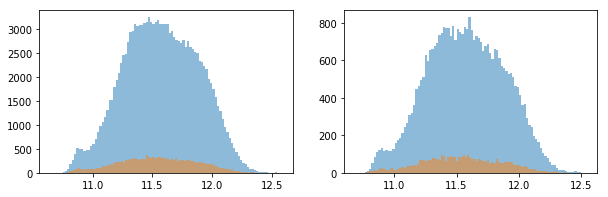

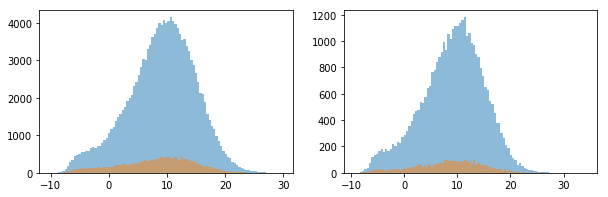

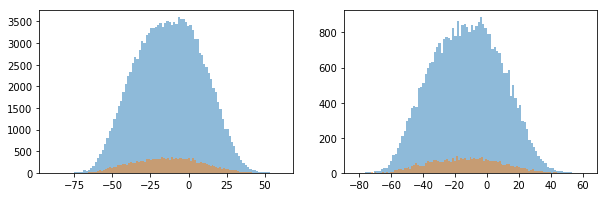

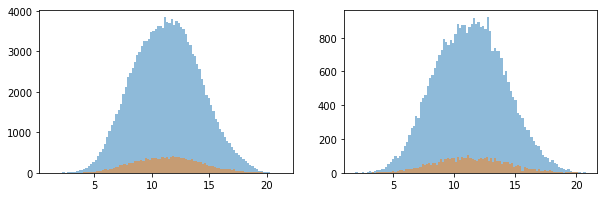

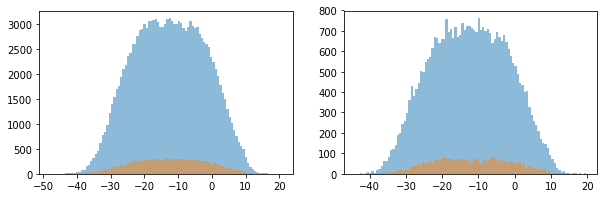

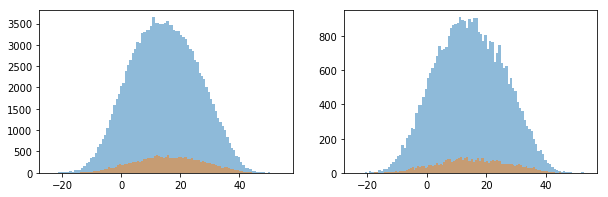

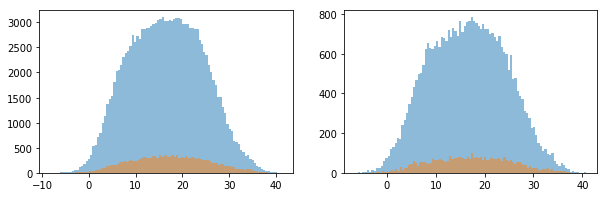

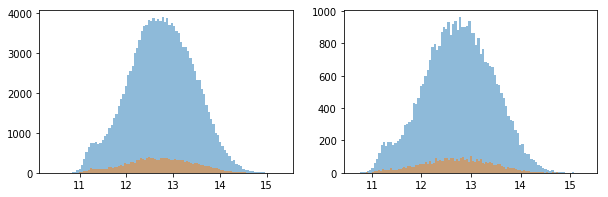

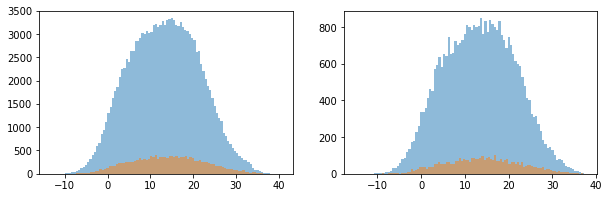

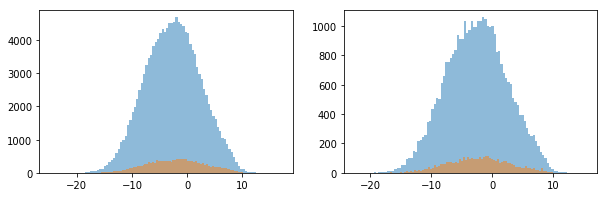

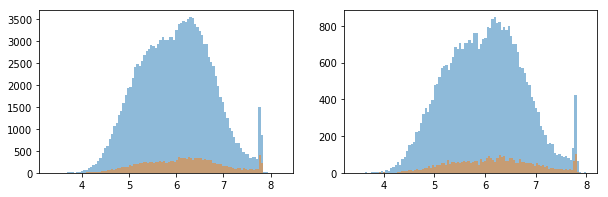

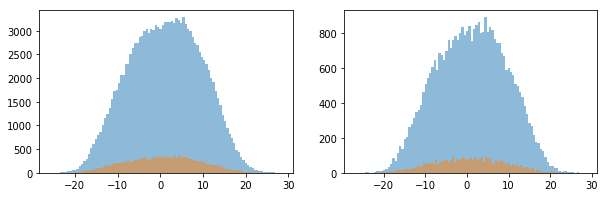

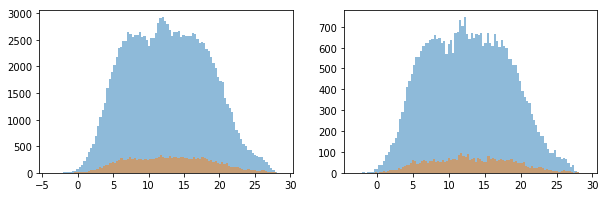

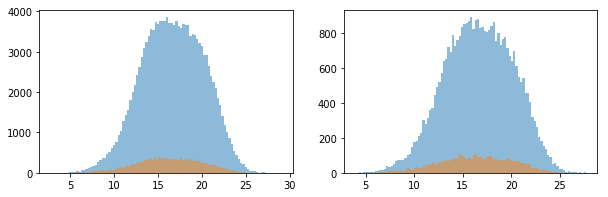

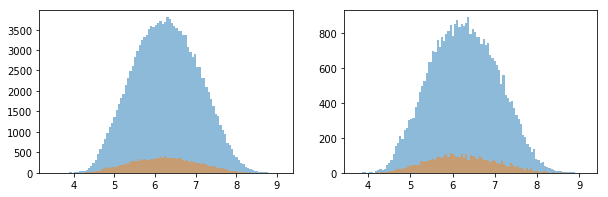

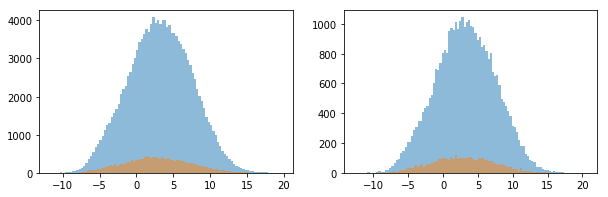

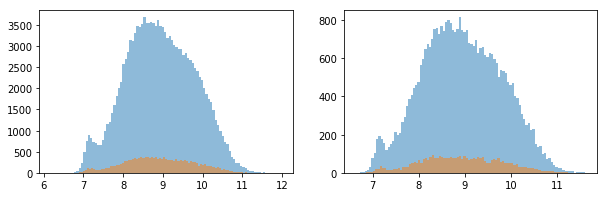

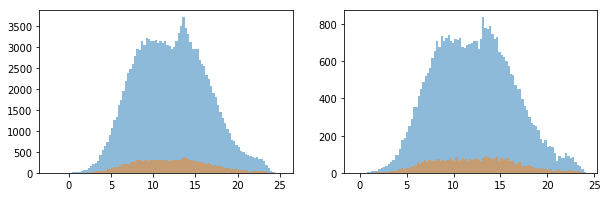

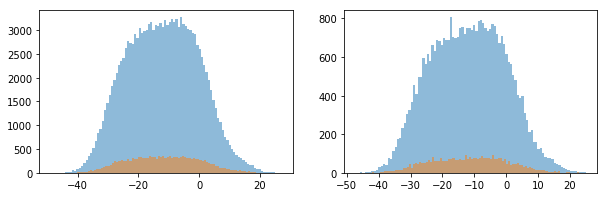

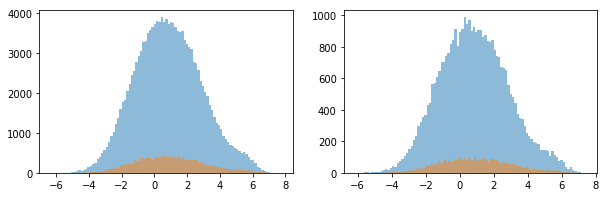

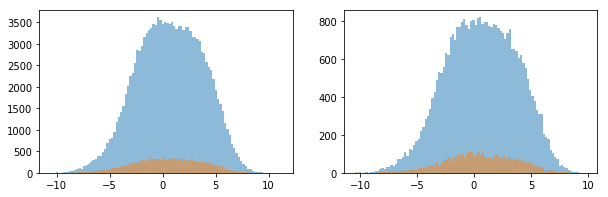

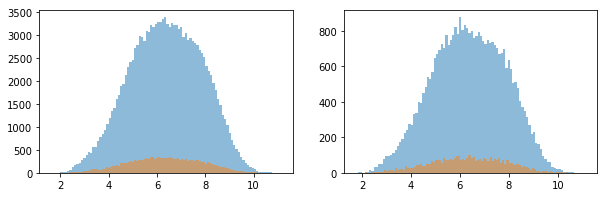

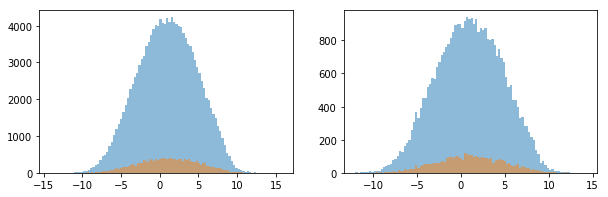

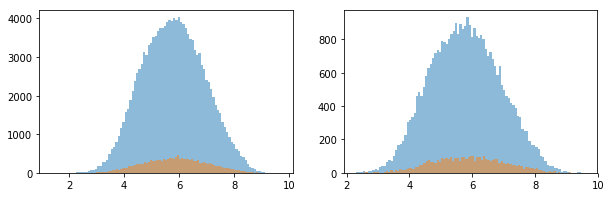

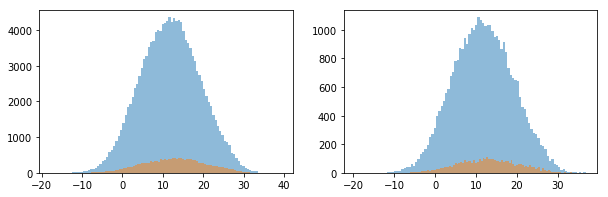

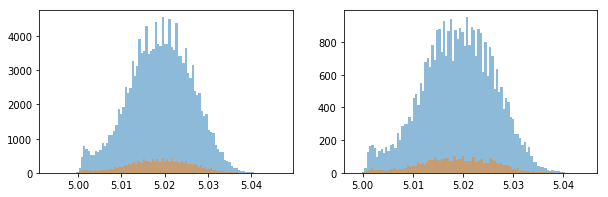

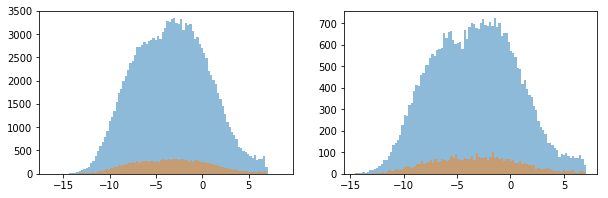

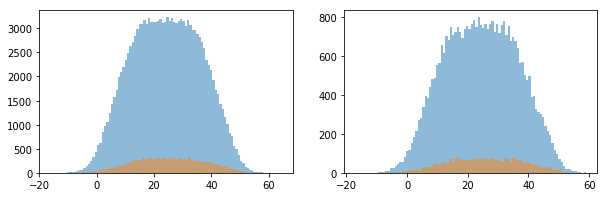

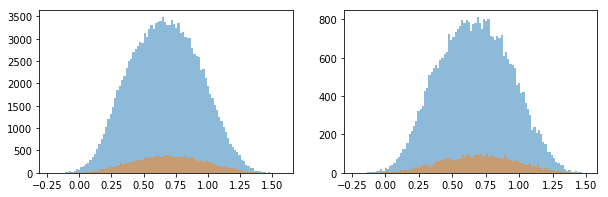

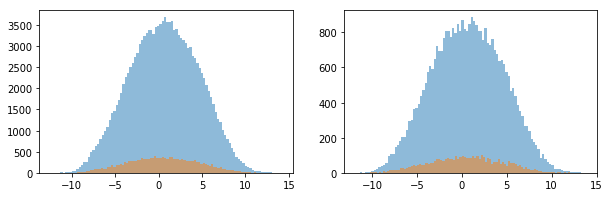

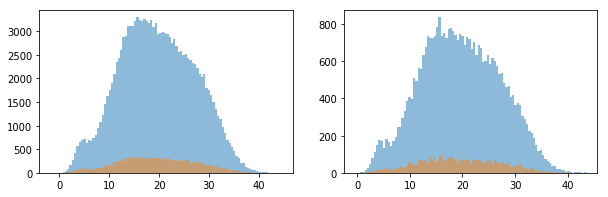

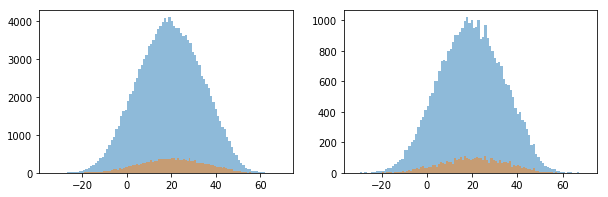

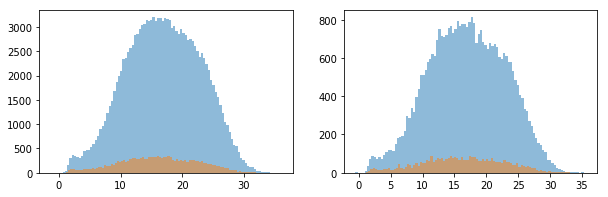

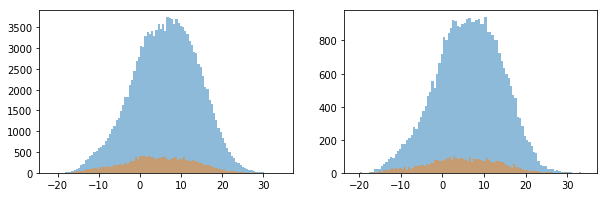

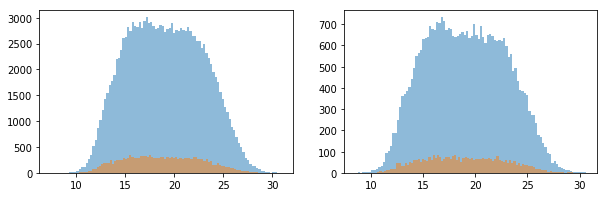

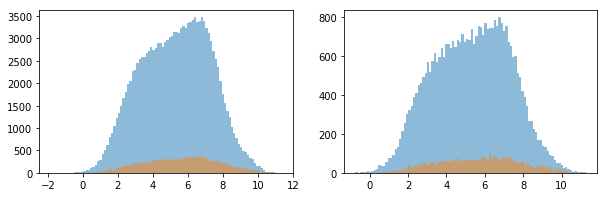

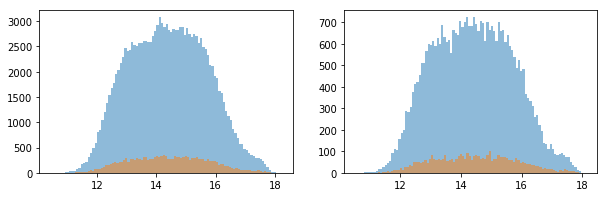

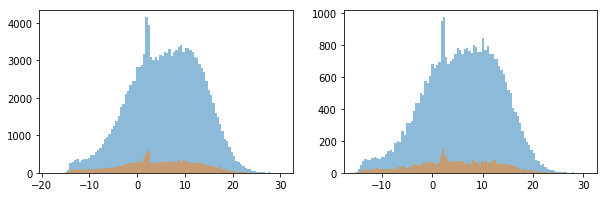

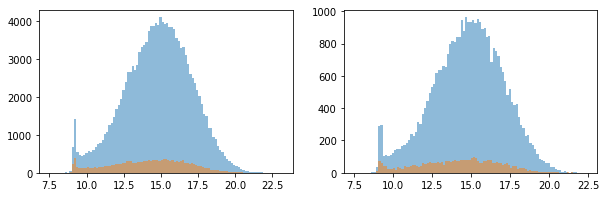

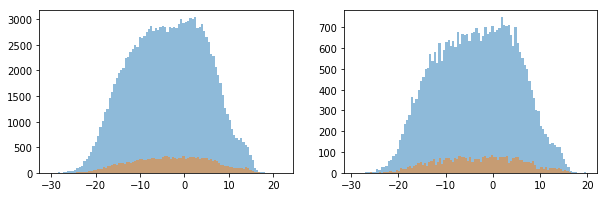

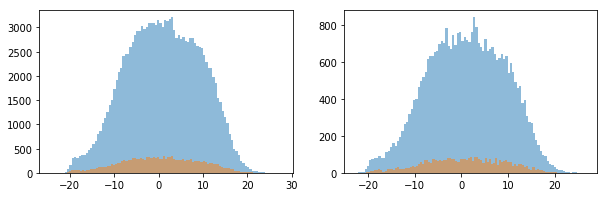

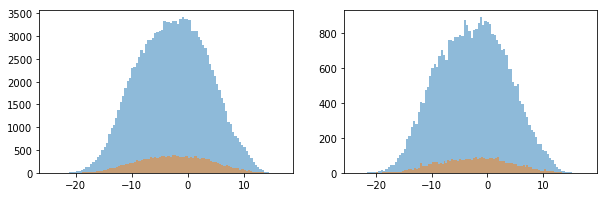

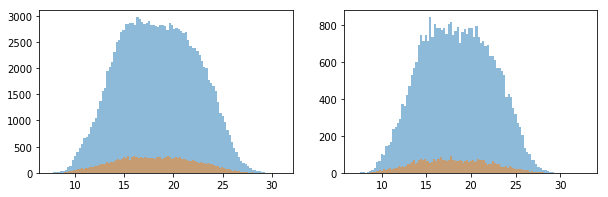

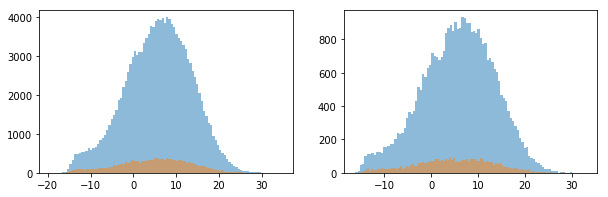

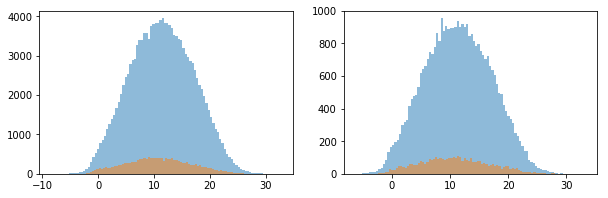

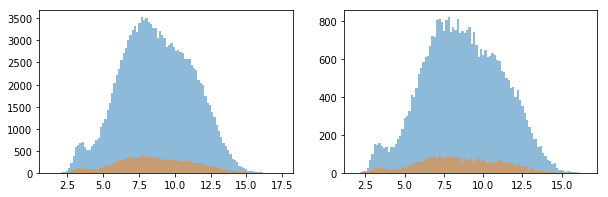

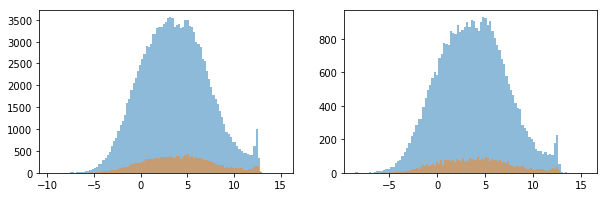

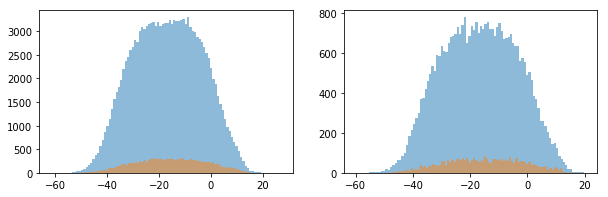

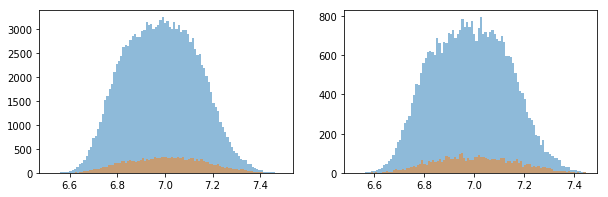

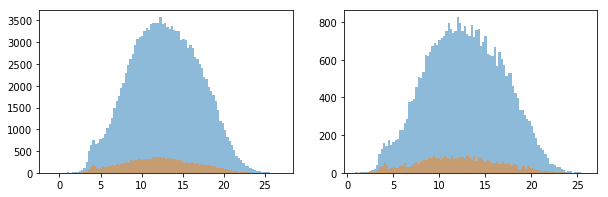

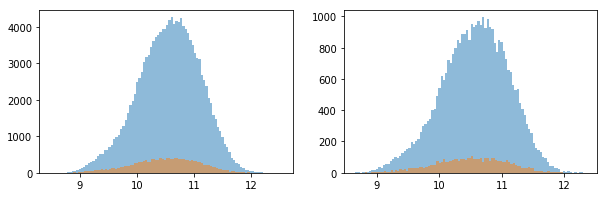

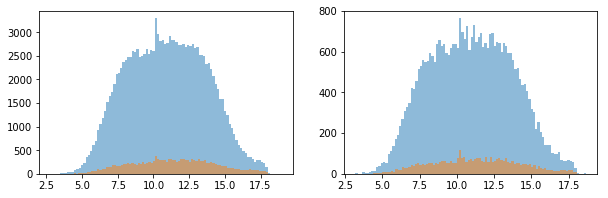

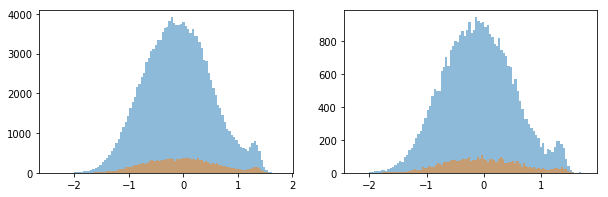

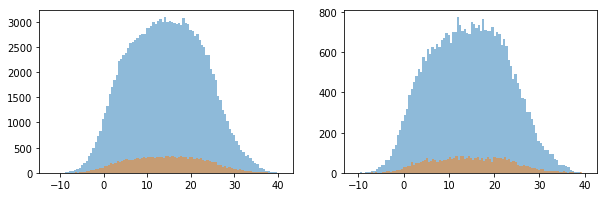

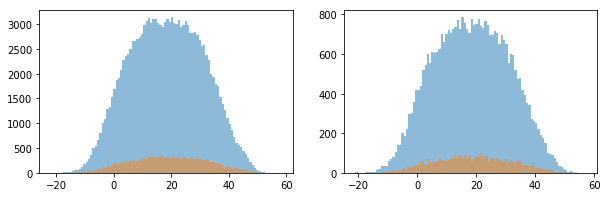

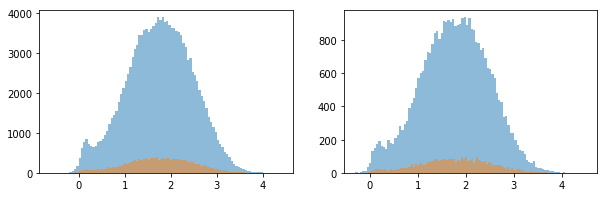

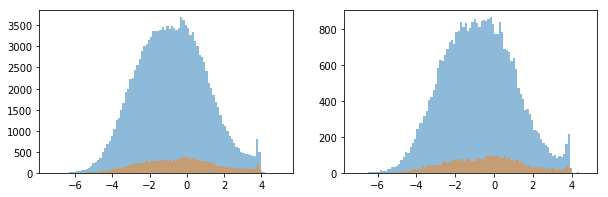

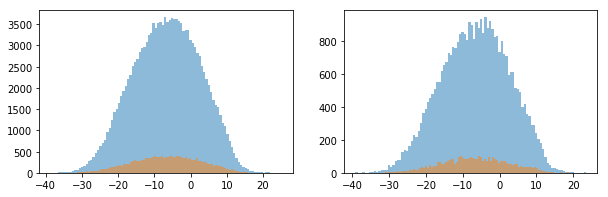

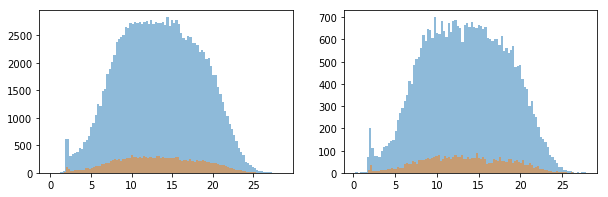

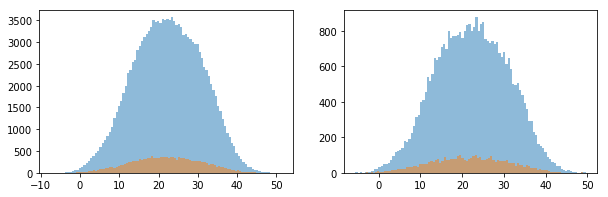

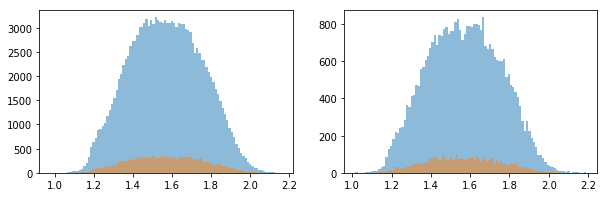

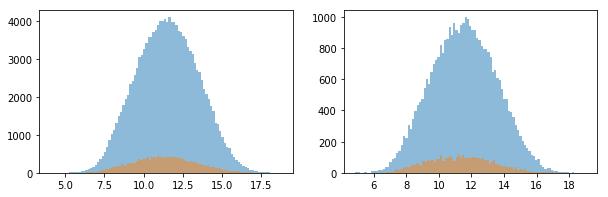

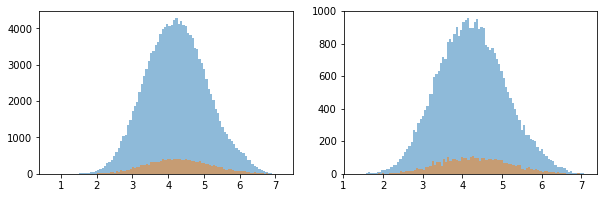

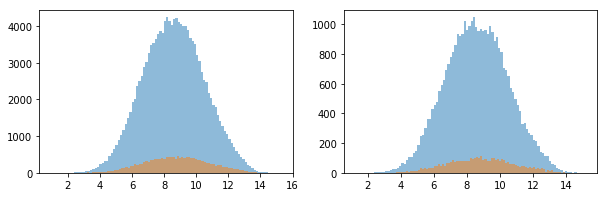

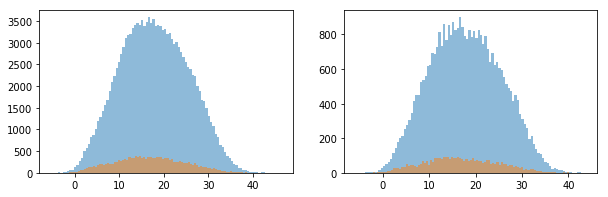

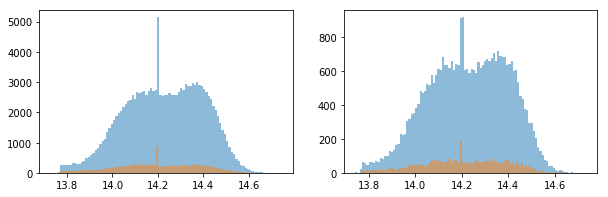

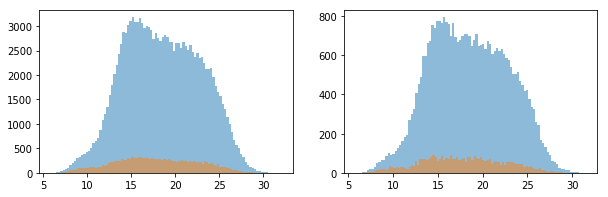

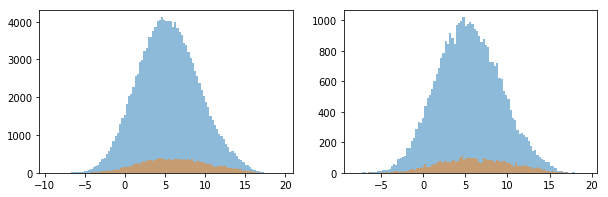

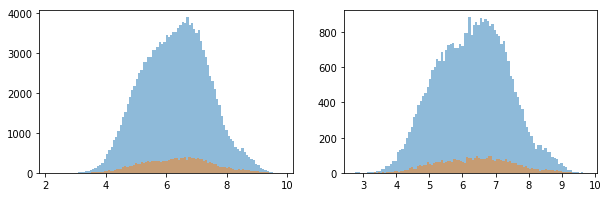

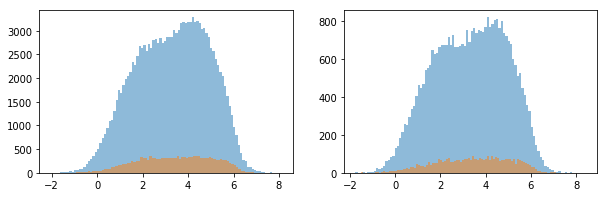

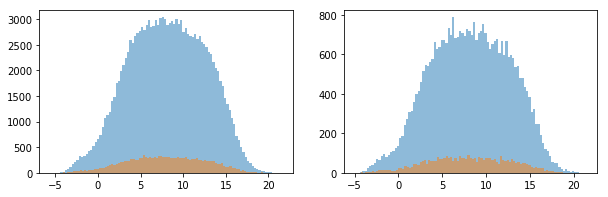

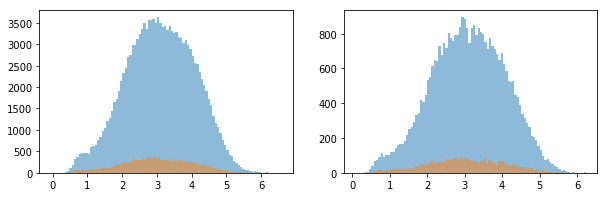

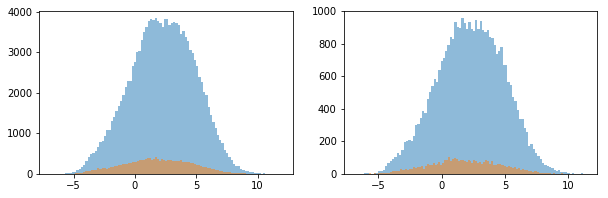

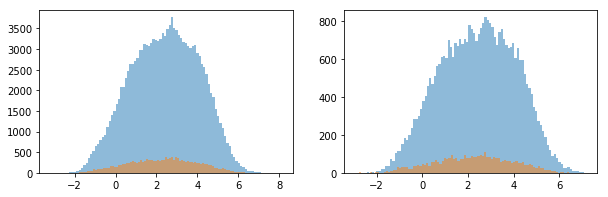

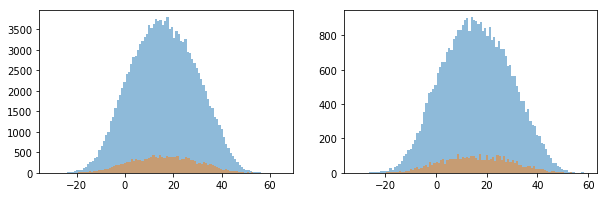

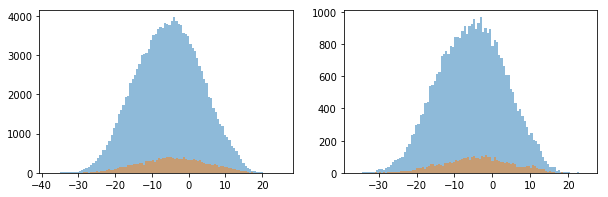

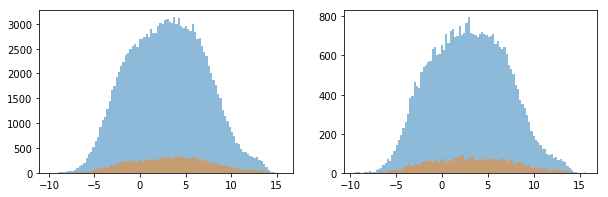

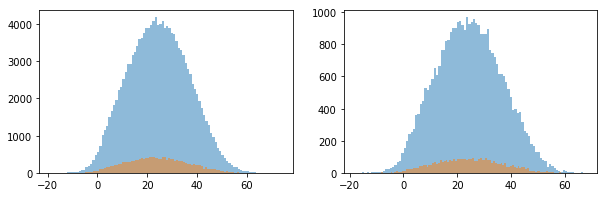

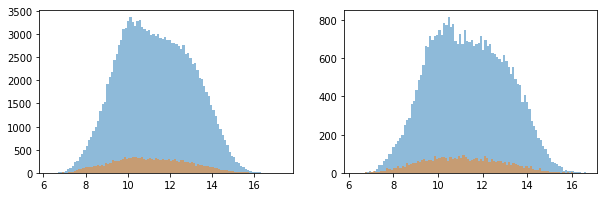

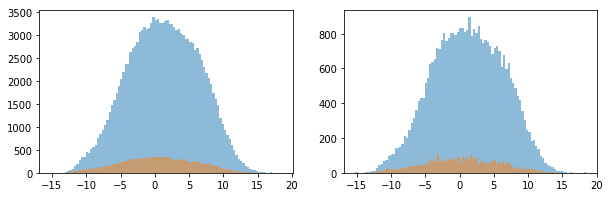

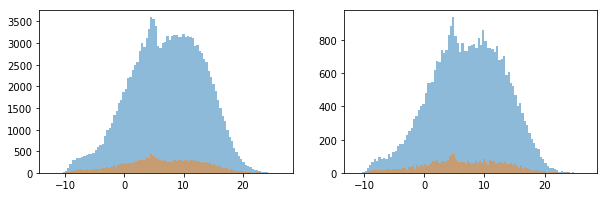

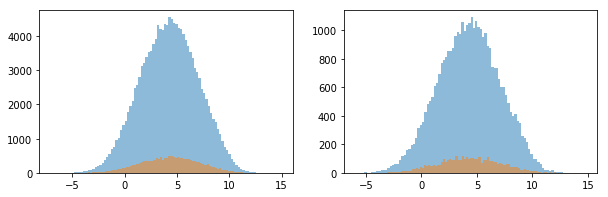

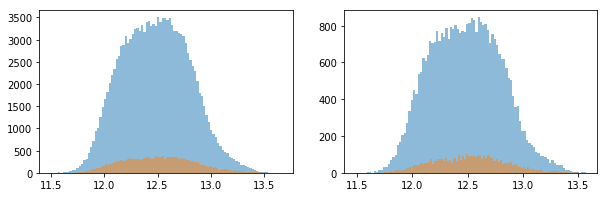

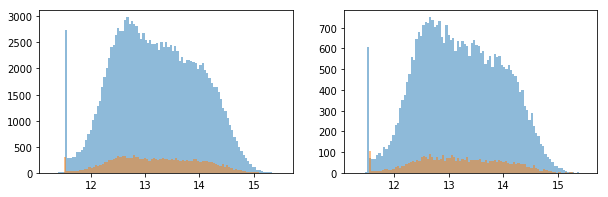

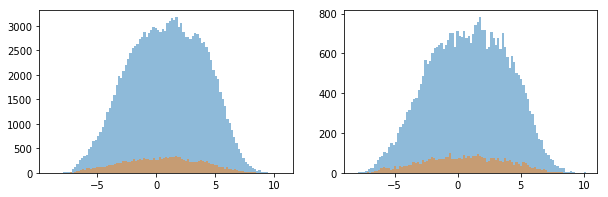

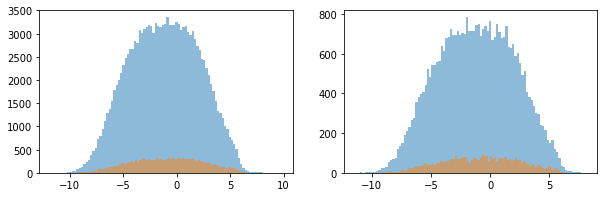

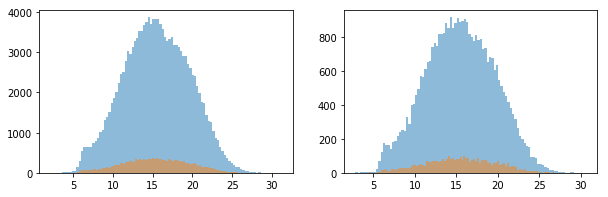

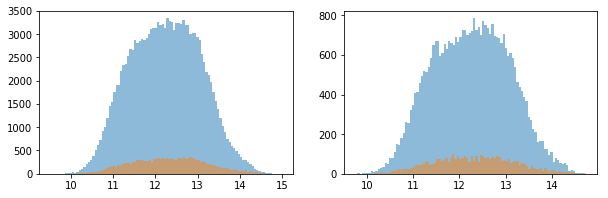

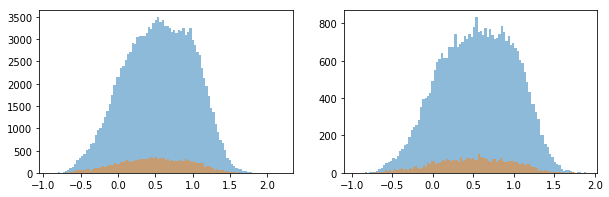

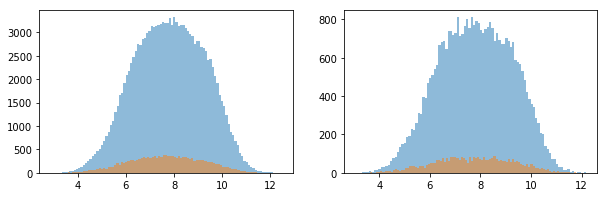

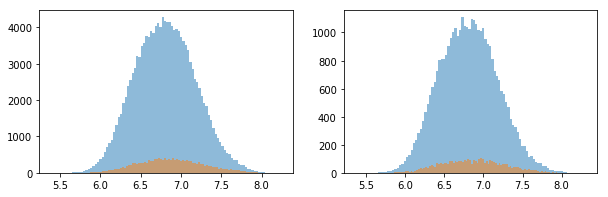

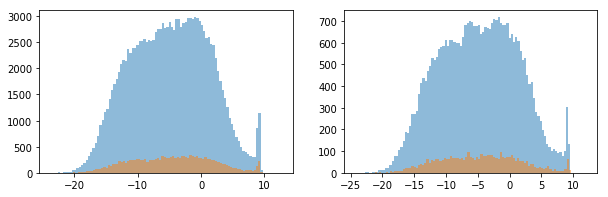

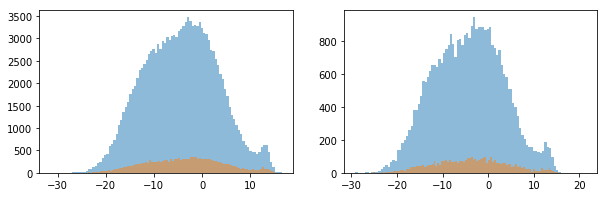

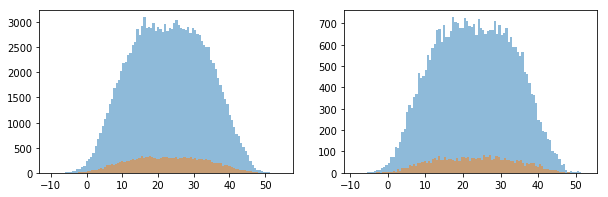

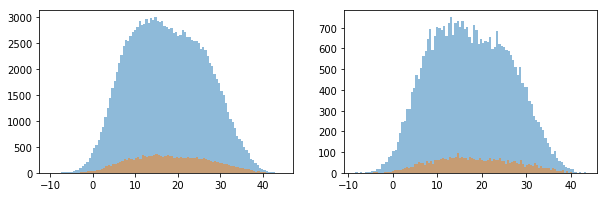

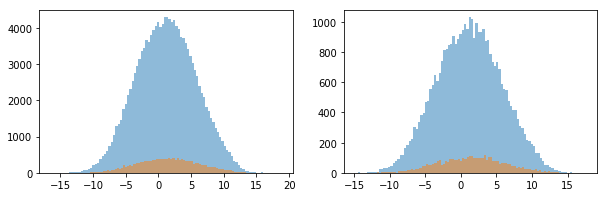

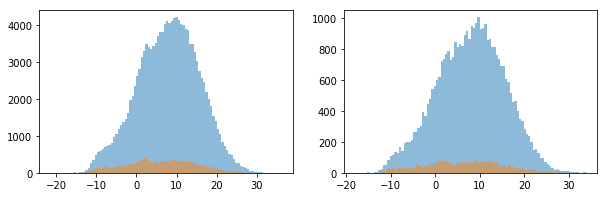

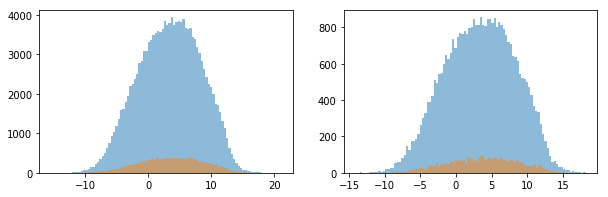

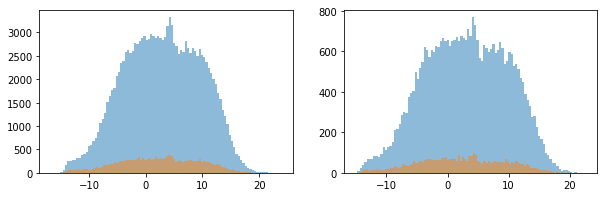

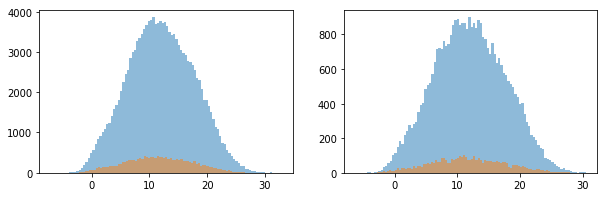

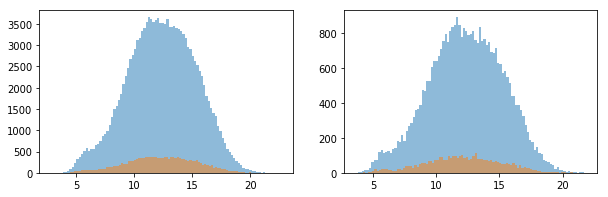

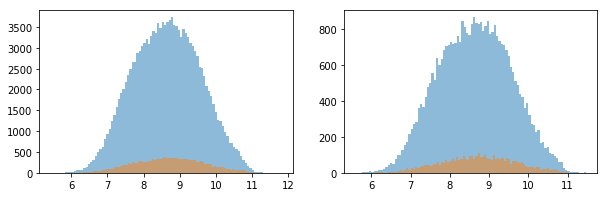

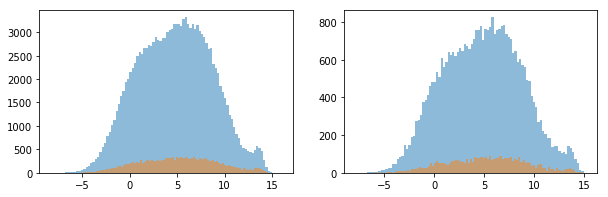

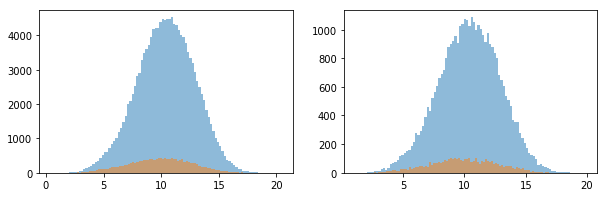

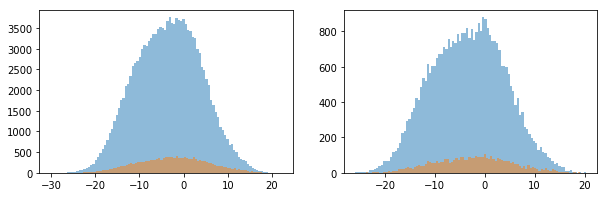

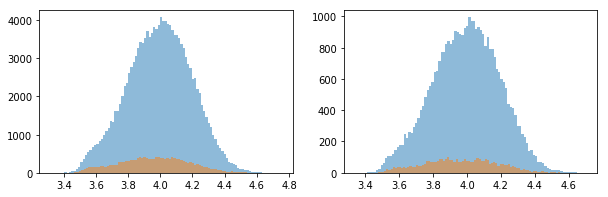

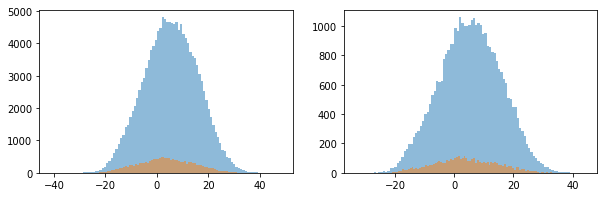

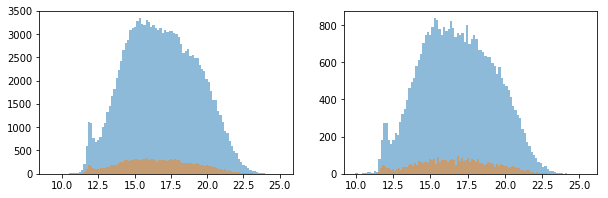

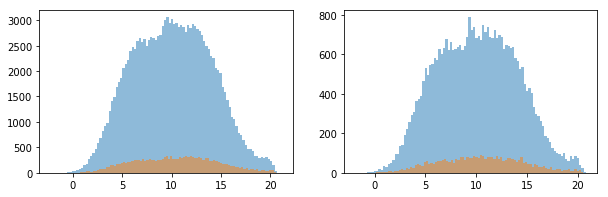

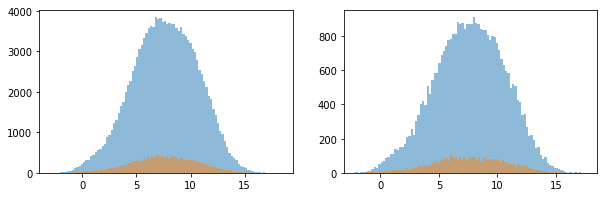

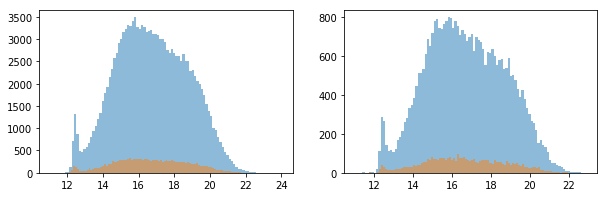

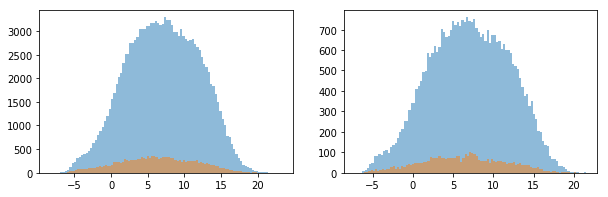

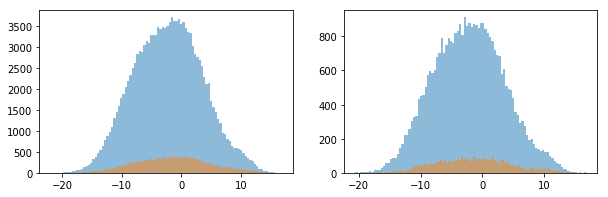

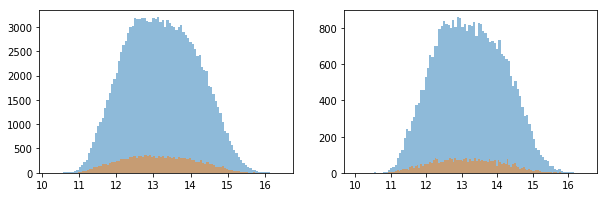

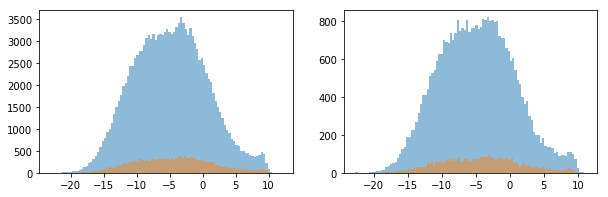

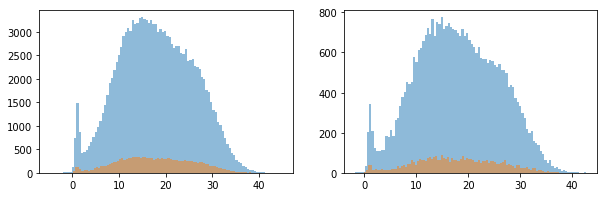

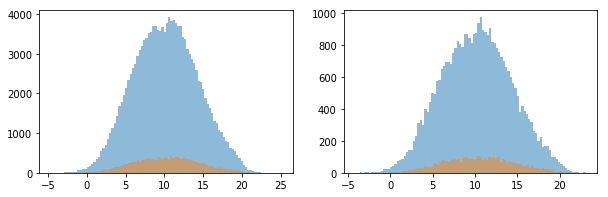

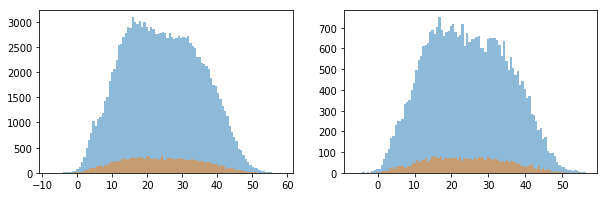

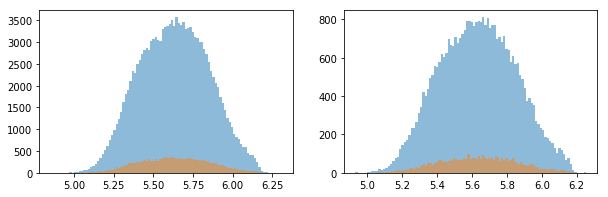

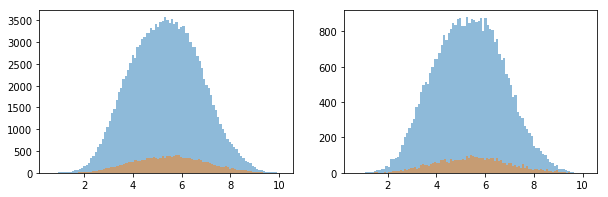

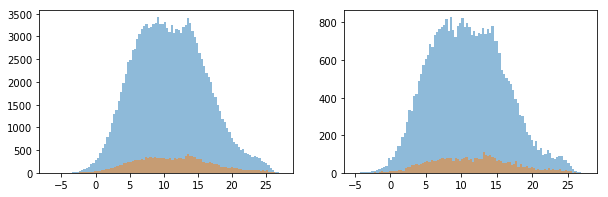

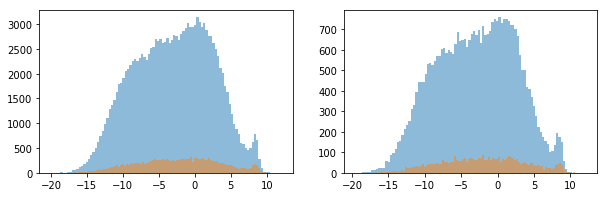

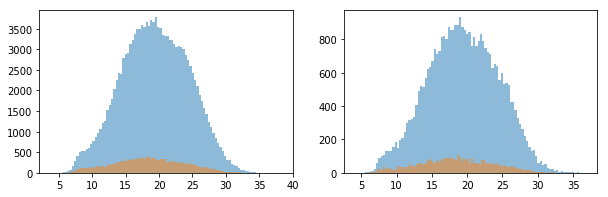

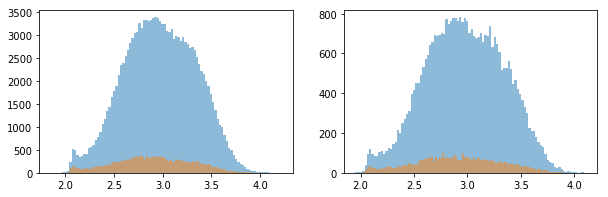

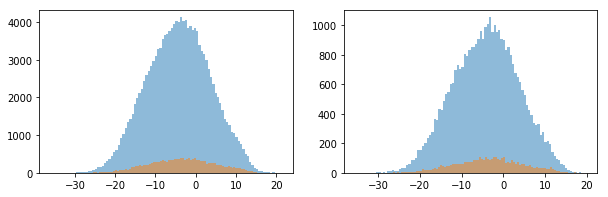

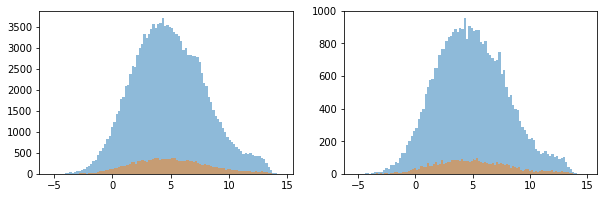

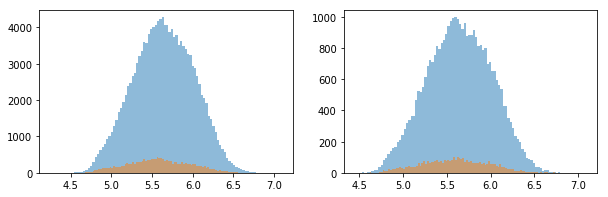

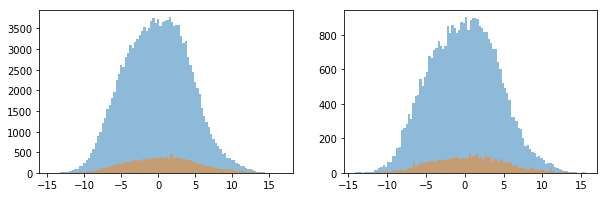

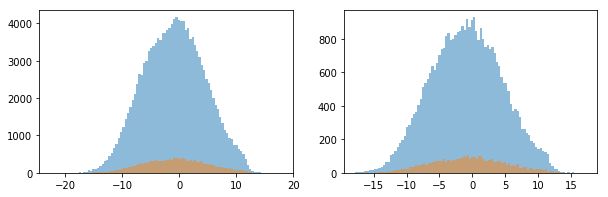

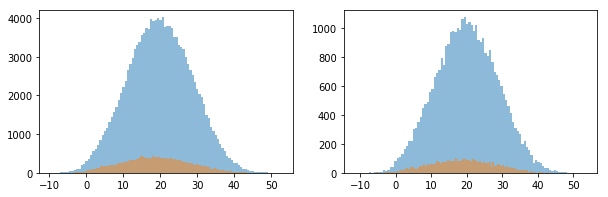

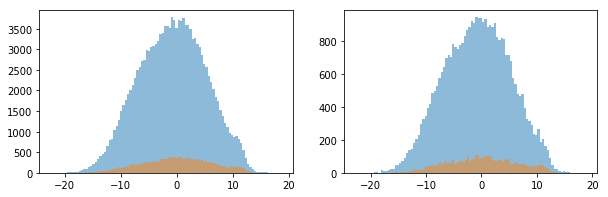

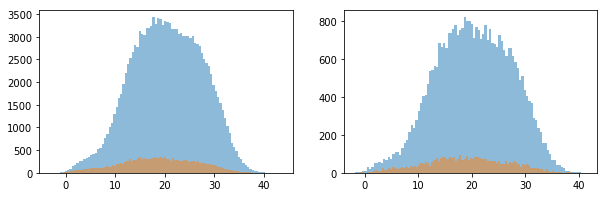

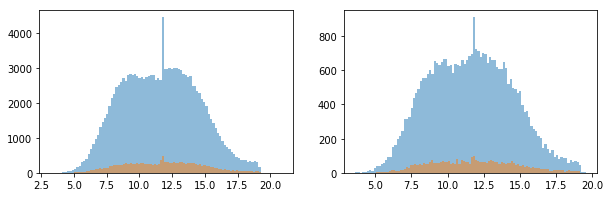

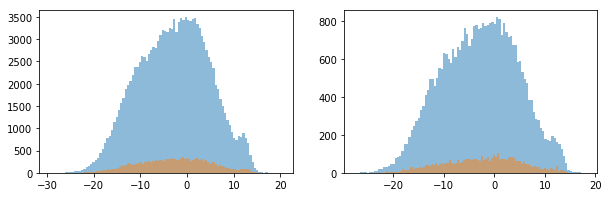

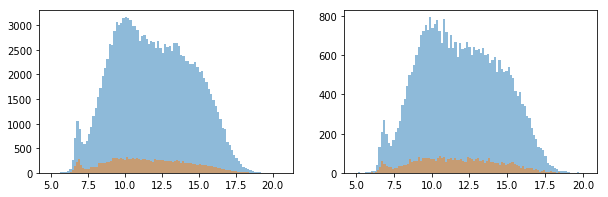

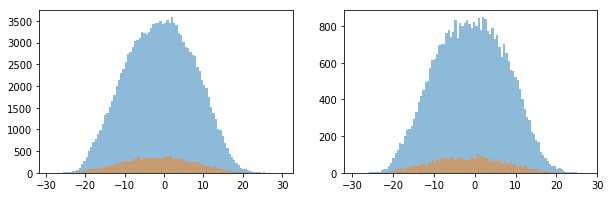

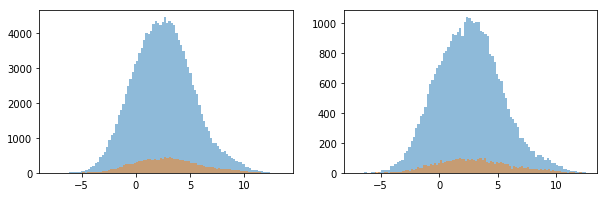

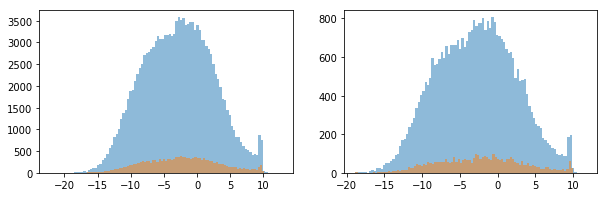

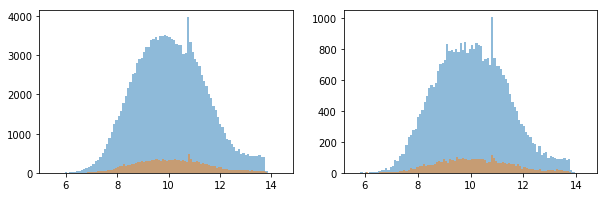

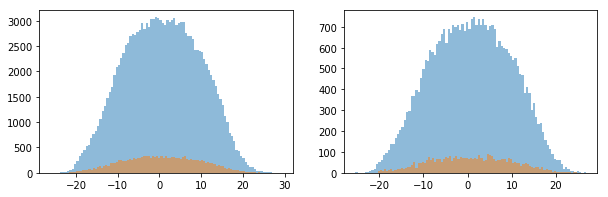

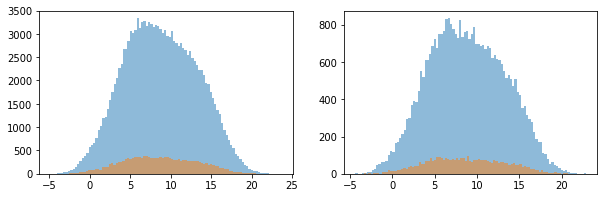

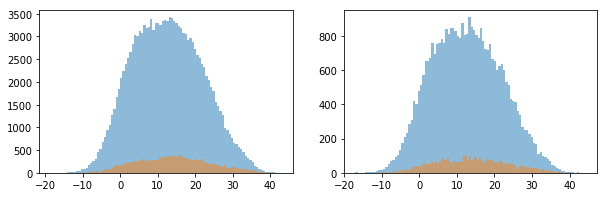

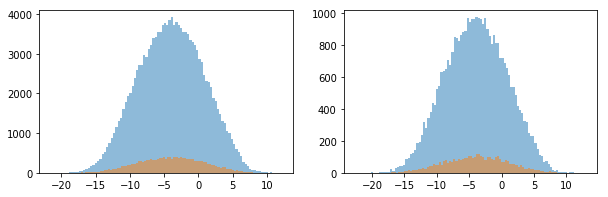

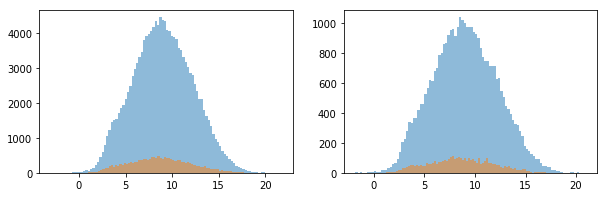

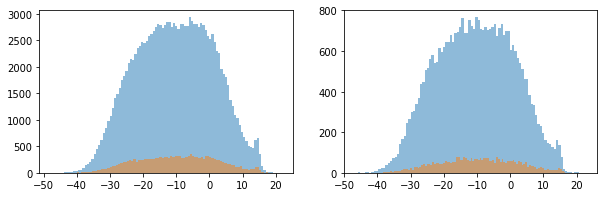

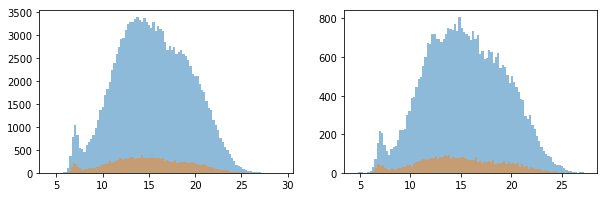

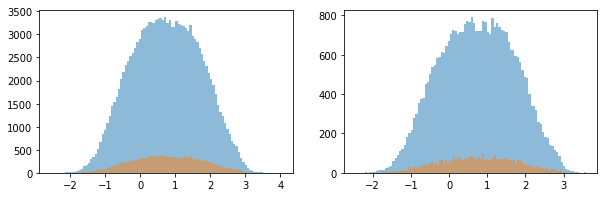

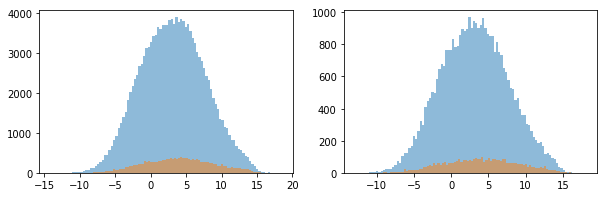

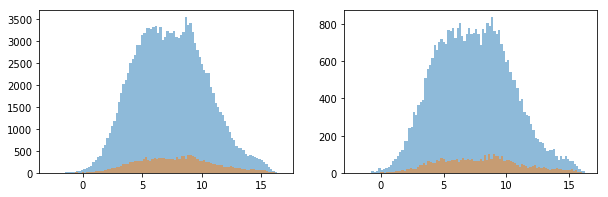

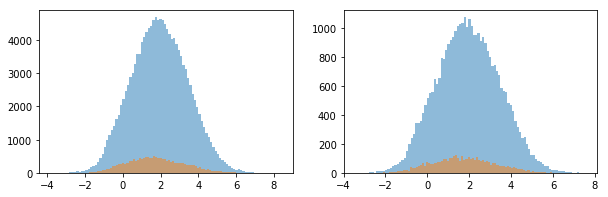

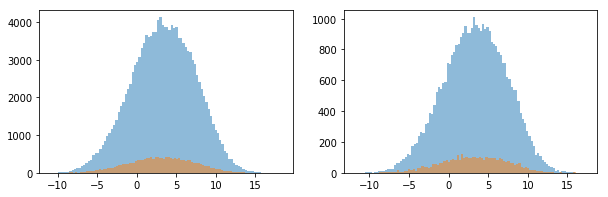

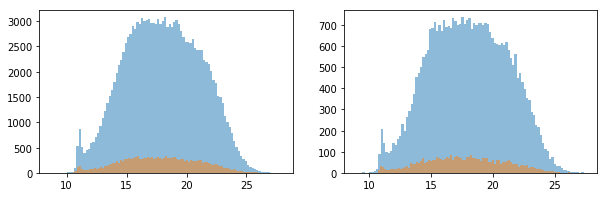

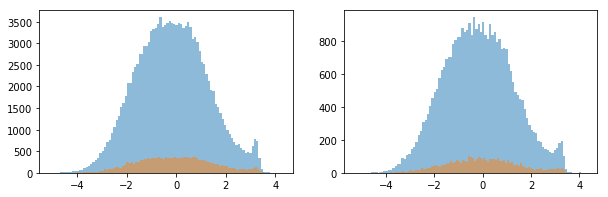

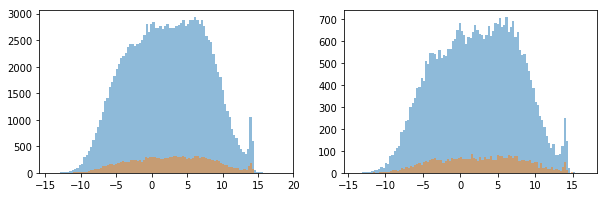

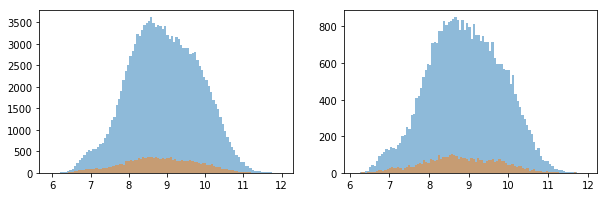

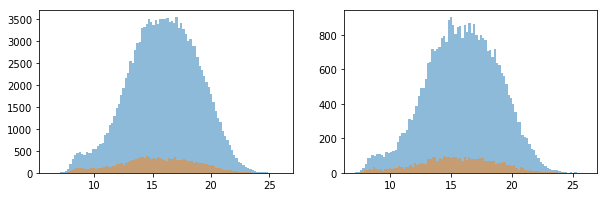

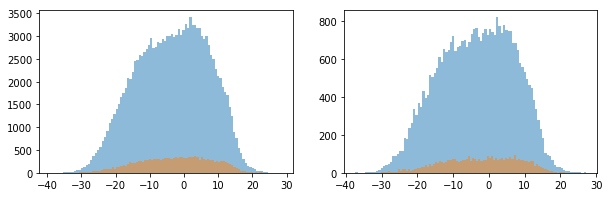

In [15]:
for i in range(200):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.hist(X_train[:, i][neg_mask_train], bins=100, alpha=0.5)
    plt.hist(X_train[:, i][pos_mask_train], bins=100, alpha=0.5)
    
    plt.subplot(1,2,2)
    plt.hist(X_val[:, i][neg_mask_val], bins=100, alpha=0.5)
    plt.hist(X_val[:, i][pos_mask_val], bins=100, alpha=0.5)
    plt.show()

------------------
0.935498310088453


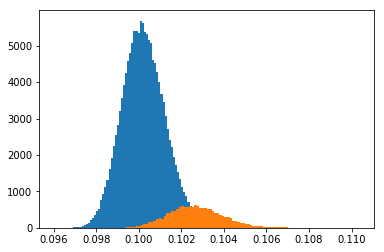

In [16]:
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, post_train.mean(axis=1))
auc_train = metrics.auc(fpr_train, tpr_train)

print('------------------')
print(auc_train)

plt.hist(post_train.mean(axis=1)[neg_mask_train], bins=100)
plt.hist(post_train.mean(axis=1)[pos_mask_train], bins=100)
plt.show()

0.8714307838240704


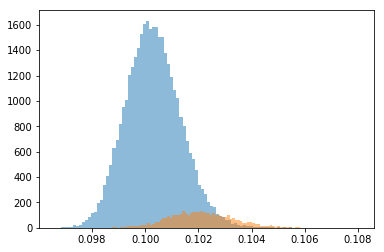

In [17]:
fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, post_val.sum(axis=1))
auc_val = metrics.auc(fpr_val, tpr_val)
print(auc_val)

plt.hist(post_val.mean(axis=1)[neg_mask_val], bins=100, alpha=0.5)
plt.hist(post_val.mean(axis=1)[pos_mask_val], bins=100, alpha=0.5)
plt.show()

In [27]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
y_train_pred_gnb = clf.predict_proba(X_train)[:,1]
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred_gnb)
auc_train = metrics.auc(fpr_train, tpr_train)

y_val_pred_gnb = clf.predict_proba(X_val)[:,1]
fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, y_val_pred_gnb)
auc_val = metrics.auc(fpr_val, tpr_val)

print('------------------')
print(auc_train)
print(auc_val)

------------------
0.890172177425396
0.8883312522988172


In [19]:
mm = MinMaxScaler()
post_train_sum = (post_train.sum(axis=1)).reshape(-1,1)
post_train_scale = mm.fit_transform(post_train_sum)
post_val_sum = (post_val.sum(axis=1)).reshape(-1,1)
post_val_scale = mm.transform(post_val_sum)

In [21]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'binary',
    'boost_from_average':False,
    'metric': 'auc',
    'boosting_type': 'gbdt', 
'feature_fraction': 0.9666651908960289, 'learning_rate': 0.04224333581709092, 'subsample': 0.9157208458236706, 'min_data_in_leaf': 54, 'min_sum_hessian_in_leaf': 0.00602878983483423, 'bagging_fraction': 0.8543386093311209, 'bagging_freq': 8, 'min_gain_to_split': 0.973776085975423, 'lambda_l1': 0.1900486044234061, 'lambda_l2': 0.4506713201194305, 'num_leaves': 21, 'max_bin': 163 
}
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_val,
                num_boost_round=10000,
                early_stopping_rounds=100,
                verbose_eval = 200) 

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.853275
[400]	valid_0's auc: 0.877762
[600]	valid_0's auc: 0.886184
[800]	valid_0's auc: 0.890585
[1000]	valid_0's auc: 0.892589
[1200]	valid_0's auc: 0.893187
[1400]	valid_0's auc: 0.893491
[1600]	valid_0's auc: 0.893616
Early stopping, best iteration is:
[1535]	valid_0's auc: 0.893788


In [22]:
y_val_pred_gbm = gbm.predict(X_val, num_iteration=gbm.best_iteration)
y_train_pred_gbm = gbm.predict(X_train, num_iteration=gbm.best_iteration)
fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, y_val_pred_gbm)
auc_val = metrics.auc(fpr_val, tpr_val)
print('------------------')
print(auc_val)

------------------
0.8937880497457127


------------------
0.8714307838240704


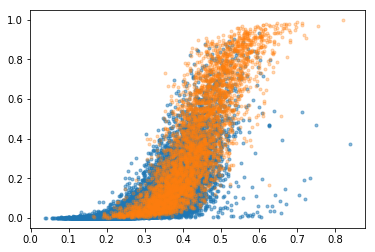

In [23]:
fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, post_val_scale)
auc_val = metrics.auc(fpr_val, tpr_val)

print('------------------')
print(auc_val)
plt.plot(post_val_scale[neg_mask_val], y_val_pred_gbm[neg_mask_val], ls='', marker='.', alpha=0.5)
plt.plot(post_val_scale[pos_mask_val], y_val_pred_gbm[pos_mask_val], ls='', marker='.', alpha=0.3)
plt.show()

In [24]:
lgb_post_train = lgb.Dataset(post_train, y_train)
lgb_post_val = lgb.Dataset(post_val, y_val, reference=lgb_post_train)

params = {
    'objective': 'binary',
    'boost_from_average':False,
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'feature_fraction': 0.9666651908960289, 'learning_rate': 0.04224333581709092, 'subsample': 0.9157208458236706, 'min_data_in_leaf': 54, 'min_sum_hessian_in_leaf': 0.00602878983483423, 'bagging_fraction': 0.8543386093311209, 'bagging_freq': 8, 'min_gain_to_split': 0.973776085975423, 'lambda_l1': 0.1900486044234061, 'lambda_l2': 0.4506713201194305, 'num_leaves': 21, 'max_bin': 163 
}
gbm_post = lgb.train(params,
                lgb_post_train,
                valid_sets=lgb_post_val,
                num_boost_round=10000,
                early_stopping_rounds=100,
                verbose_eval = 200) 

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.848939
[400]	valid_0's auc: 0.868819
[600]	valid_0's auc: 0.874389
[800]	valid_0's auc: 0.876166
Early stopping, best iteration is:
[848]	valid_0's auc: 0.876386


In [25]:
y_val_pred_gbm_post = gbm_post.predict(post_val, num_iteration=gbm_post.best_iteration)
y_train_pred_gbm_post = gbm_post.predict(post_train, num_iteration=gbm_post.best_iteration)
fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, y_val_pred_gbm_post)
auc_val = metrics.auc(fpr_val, tpr_val)
print('------------------')
print(auc_val)

------------------
0.8763860588663134


------------------
0.8970474199320242


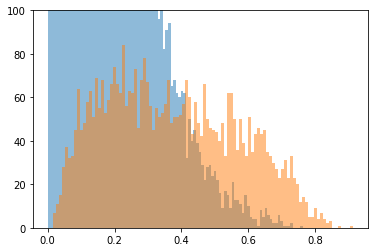

<function matplotlib.pyplot.show(*args, **kw)>

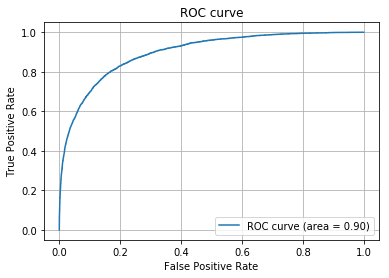

In [48]:
com_val = ((post_val_scale**10)
           * (y_val_pred_gnb.reshape(-1,1)**4)
           * (y_val_pred_gbm.reshape(-1,1)**7)
           * (y_val_pred_gbm_post.reshape(-1,1)**1)) ** (1/22)

fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, com_val)
auc_val = metrics.auc(fpr_val, tpr_val)

print('------------------')
print(auc_val)

plt.hist(com_val[neg_mask_val], bins=100, alpha=0.5)
plt.hist(com_val[pos_mask_val], bins=100, alpha=0.5)
plt.ylim(0,100)
plt.show()

plt.plot(fpr_val, tpr_val, label='ROC curve (area = %.2f)'%auc_val)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show

------------------
0.8883734053468069


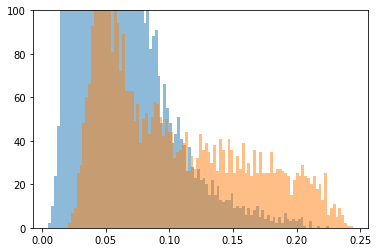

<function matplotlib.pyplot.show(*args, **kw)>

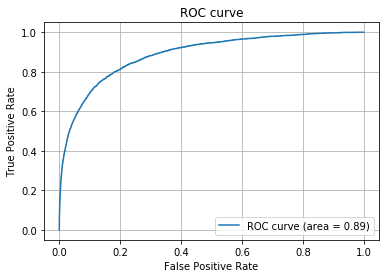

In [45]:
com_val = ((post_val_scale**3)
           + (y_val_pred.reshape(-1,1)**3)
           + 5 * (y_val_pred_gbm.reshape(-1,1)**3)
           + (y_val_pred_gbm_post.reshape(-1,1)**3)) ** (1/3) / 8

fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, com_val)
auc_val = metrics.auc(fpr_val, tpr_val)

print('------------------')
print(auc_val)

plt.hist(com_val[neg_mask_val], bins=100, alpha=0.5)
plt.hist(com_val[pos_mask_val], bins=100, alpha=0.5)
plt.ylim(0,100)
plt.show()

plt.plot(fpr_val, tpr_val, label='ROC curve (area = %.2f)'%auc_val)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show

In [32]:
feats_val = np.hstack([post_val_scale,
                         y_val_pred_gnb.reshape(-1,1),
                         y_val_pred_gbm.reshape(-1,1),
                         y_val_pred_gbm_post.reshape(-1,1)])

In [33]:
feats_train = np.hstack([post_train_scale,
                         y_train_pred_gnb.reshape(-1,1),
                         y_train_pred_gbm.reshape(-1,1),
                         y_train_pred_gbm_post.reshape(-1,1)])

In [34]:
pca = PCA()
pca.fit(feats_train)
trans_val = pca.transform(feats_val)

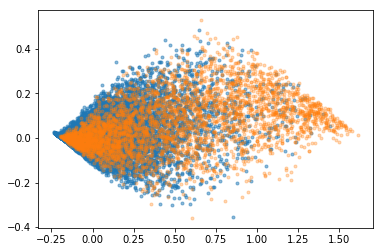

In [35]:
plt.plot(trans_val[:,0][neg_mask_val], trans_val[:,1][neg_mask_val], ls='', marker='.', alpha=0.5)
plt.plot(trans_val[:,0][pos_mask_val], trans_val[:,1][pos_mask_val], ls='', marker='.', alpha=0.3)
plt.show()

------------------
0.895456645344705


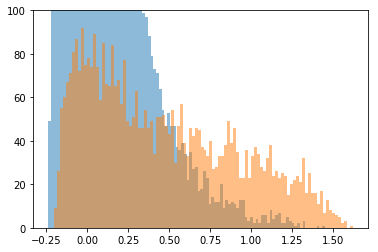

------------------
0.6553543635352973


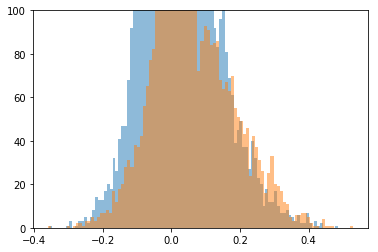

------------------
0.4892126637518356


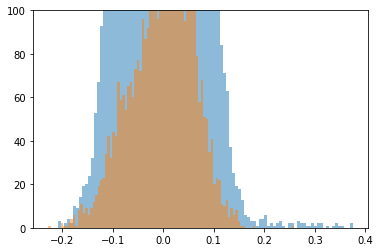

------------------
0.604296216250598


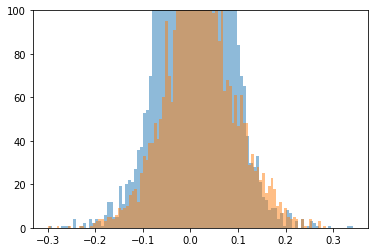

In [36]:
for i in range(4):
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, trans_val[:,i])
    auc_val = metrics.auc(fpr_val, tpr_val)

    print('------------------')
    print(auc_val)
    plt.hist(trans_val[:,i][neg_mask_val], bins=100, alpha=0.5)
    plt.hist(trans_val[:,i][pos_mask_val], bins=100, alpha=0.5)
    plt.ylim(0,100)
    plt.show()  

In [37]:
mlp1 = MLPClassifier(hidden_layer_sizes=(200,50), activation='relu')

sc =  StandardScaler()
X_train_norm = sc.fit_transform(X_train)
mlp1.fit(X_train_norm, y_train)

y_train_pred_mlp1 = mlp1.predict_proba(X_train)[:,1]
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred_mlp1)
auc_train = metrics.auc(fpr_train, tpr_train)

X_val_norm = sc.transform(X_val)
y_val_pred_mlp1 = mlp1.predict_proba(X_val_norm)[:,1]
fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, y_val_pred_mlp1)
auc_val = metrics.auc(fpr_val, tpr_val)

print('------------------')
print(auc_train)
print(auc_val)

------------------
0.5979170894127064
0.7531444051283328


In [49]:
mlp2 = MLPClassifier(hidden_layer_sizes=(200,50), activation='logistic')

mlp2.fit(post_train_scale, y_train)

y_train_pred_mlp2 = mlp2.predict_proba(post_train_scale)[:,1]
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred_mlp2)
auc_train = metrics.auc(fpr_train, tpr_train)

y_val_pred_mlp2 = mlp2.predict_proba(post_val_scale)[:,1]
fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, y_val_pred_mlp2)
auc_val = metrics.auc(fpr_val, tpr_val)

print('------------------')
print(auc_train)
print(auc_val)

------------------
0.935498310088453
0.8714307838240704


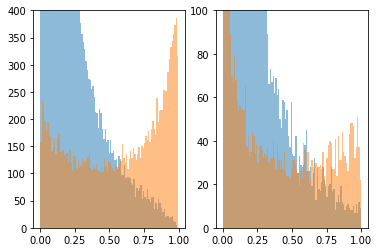

In [50]:
plt.subplot(1,2,1)
plt.hist(y_train_pred_mlp2[neg_mask_train], bins=100, alpha=0.5)
plt.hist(y_train_pred_mlp2[pos_mask_train], bins=100, alpha=0.5)
plt.ylim(0, 400)

plt.subplot(1,2,2)
plt.hist(y_val_pred_mlp2[neg_mask_val], bins=100, alpha=0.5)
plt.hist(y_val_pred_mlp2[pos_mask_val], bins=100, alpha=0.5)
plt.ylim(0, 100)
plt.show()

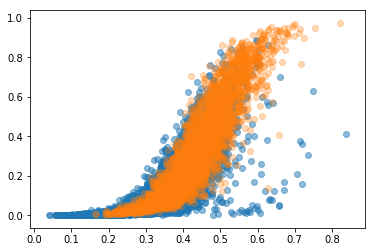

In [57]:
plt.scatter(post_val_scale[neg_mask_val], y_val_pred_gbm_post[neg_mask_val],alpha=0.5)
plt.scatter(post_val_scale[pos_mask_val], y_val_pred_gbm_post[pos_mask_val],alpha=0.3)

------------------
0.8883734053468069


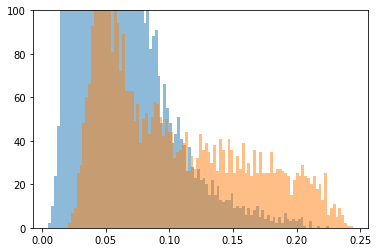

<function matplotlib.pyplot.show(*args, **kw)>

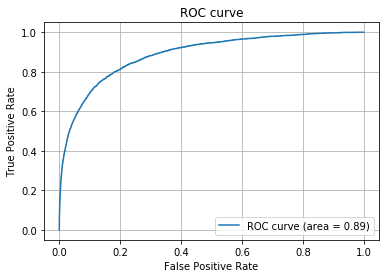

In [29]:
com_val = ((post_val_scale**3)
           + (y_val_pred_gnb.reshape(-1,1)**3)
           + 5 * (y_val_pred_gbm.reshape(-1,1)**3)
           + (y_val_pred_gbm_post.reshape(-1,1)**3)) ** (1/3) / 8

fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, com_val)
auc_val = metrics.auc(fpr_val, tpr_val)

print('------------------')
print(auc_val)

plt.hist(com_val[neg_mask_val], bins=100, alpha=0.5)
plt.hist(com_val[pos_mask_val], bins=100, alpha=0.5)
plt.ylim(0,100)
plt.show()

plt.plot(fpr_val, tpr_val, label='ROC curve (area = %.2f)'%auc_val)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show

In [ ]:
com_val = ((post_val_scale**4)
           * (y_val_pred.reshape(-1,1)**2)
           * (y_val_pred_gbm.reshape(-1,1)**3)
           * (y_val_pred_gbm_post.reshape(-1,1)**1)
          * y_val_pred_mlp1.reshape(-1,1)**1) ** (1/11)

fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, com_val)
auc_val = metrics.auc(fpr_val, tpr_val)

print('------------------')
print(auc_val)

plt.hist(com_val[neg_mask_val], bins=100, alpha=0.5)
plt.hist(com_val[pos_mask_val], bins=100, alpha=0.5)
plt.show()

In [303]:
mm_neg = MinMaxScaler()
mm_neg.fit(X_train[neg_mask_train])
X_train_neg_norm = mm_neg.transform(X_train[neg_mask_train])
X_val_neg_norm = mm_neg.transform(X_val[neg_mask_val])

mm_pos = MinMaxScaler()
mm_pos.fit(X_train[pos_mask_train])
X_train_pos_norm = mm_pos.transform(X_train[pos_mask_train])
X_val_pos_norm = mm_pos.transform(X_val[pos_mask_val])

In [331]:
train_means = df_train_describe.iloc[1].values[1:]
val_means = df_val_describe.iloc[1].values[1:]

In [365]:
train_means_stnd = sc_neg.transform(train_means.reshape(-1,200))
val_means_stnd = sc_neg.transform(val_means.reshape(-1,200))

In [366]:
num = X_train_pos_stnd.shape[0]
X_train_pos_scores = np.zeros(num)
for i in range(num):
    X_train_pos_scores[i] =  (X_train_pos_stnd[i] * train_means_stnd).sum(axis=1)[0]

    
num = X_train_neg_stnd.shape[0]
X_train_neg_scores = np.zeros(num)
for i in range(num):
    X_train_neg_scores[i] =  (X_train_neg_stnd[i] * train_means_stnd).sum(axis=1)[0]

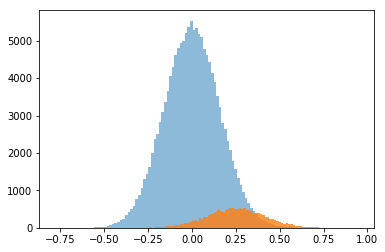

In [367]:
plt.hist(X_train_neg_scores, bins=100, alpha=0.5)
plt.hist(X_train_pos_scores, bins=100, alpha=0.8)
plt.show()

In [281]:
classifiers = [ MLPClassifier(hidden_layer_sizes=(200,), activation='logistic', alpha=1, shuffle=True, solver='adam'),  
               MLPClassifier(hidden_layer_sizes=(200,), activation='logistic', alpha=2, shuffle=True, solver='adam'),  
               MLPClassifier(hidden_layer_sizes=(200,), activation='logistic', alpha=3, shuffle=True, solver='adam'),  
            ]

In [282]:
clfs = []
for clf in classifiers:
    name = str(clf).split('(')[0]
    print('fitting with %s.....' % name)
    clf.fit(post_train, y_train)
    clfs.append(clf)

fitting with MLPClassifier.....
fitting with MLPClassifier.....
fitting with MLPClassifier.....


In [283]:
predicts_train = []
predicts_val = []
for clf in clfs:
    name = str(clf).split('(')[0]
    print('predicting with %s.....' % name)
    if hasattr(clf,'predict_proba') == True:
        pred_train = clf.predict_proba(post_train)[:,1]
        pred_val = clf.predict_proba(post_val)[:,1]
        predicts_train.append(pred_train)
        predicts_val.append(pred_val)
    else:
        pred_train = clf.predict(post_train)
        pred_val = clf.predict(post_val)
        predicts_train.append(pred_train)
        predicts_val.append(pred_val)
        
predicts_train_arr = np.array(predicts_train).T
predicts_val_arr = np.array(predicts_val).T

predicting with MLPClassifier.....
predicting with MLPClassifier.....
predicting with MLPClassifier.....


------------------------------------


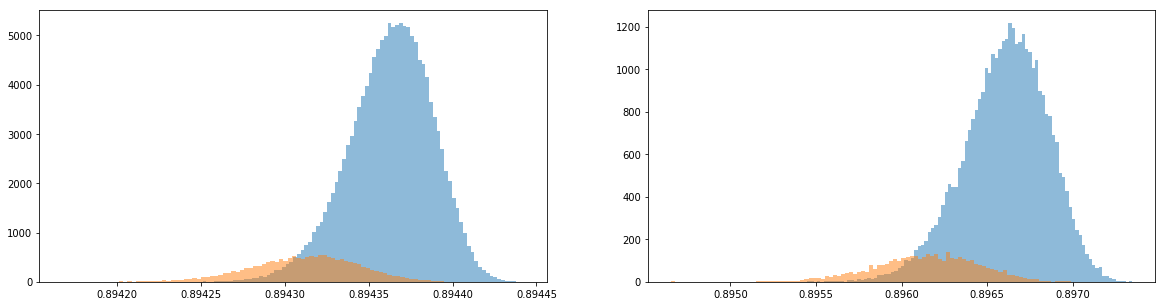

------------------------------------


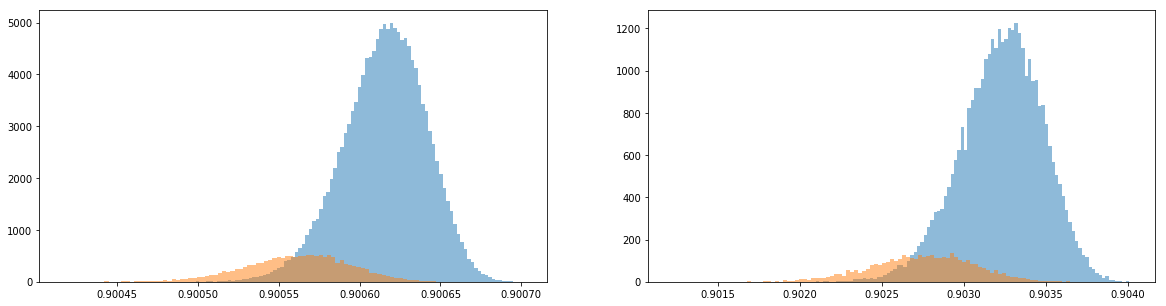

------------------------------------


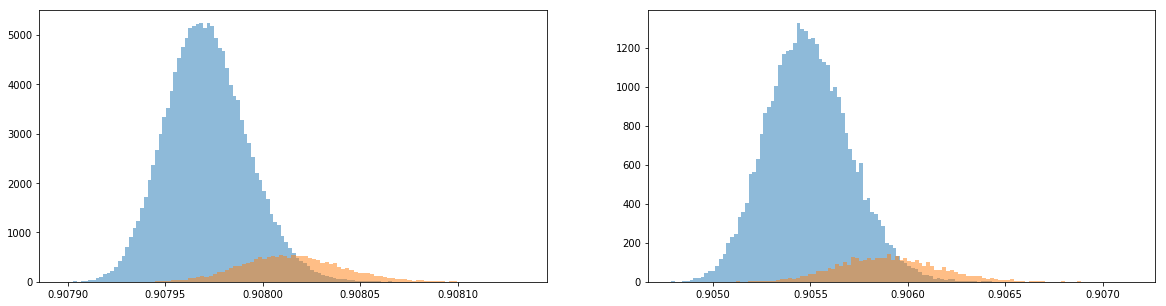

In [284]:
num = len(clfs)
for i in range(num):
    plt.figure(figsize=(20,5))
    print('------------------------------------')
    plt.subplot(1,2,1)
    plt.hist(predicts_train_arr[:, i][neg_mask_train], bins=100, alpha=0.5)
    plt.hist(predicts_train_arr[:, i][pos_mask_train], bins=100, alpha=0.5)
    
    plt.subplot(1,2,2)
    plt.hist(predicts_val_arr[:,i][neg_mask_val], bins=100, alpha=0.5)
    plt.hist(predicts_val_arr[:,i][pos_mask_val], bins=100, alpha=0.5)
    plt.show()
